{'r0 (Hz)': 249.9919991557929, 'tau0 (ms)': 7.142857142857142, 'E0 (mV)': -42.14285714285714, 'tau0_prime (ms)': 7.089684509039348, 'E0_prime (mV)': -42.08436724565757, 'sigma2(V_th) (mV^2)': 7.486607142857144}


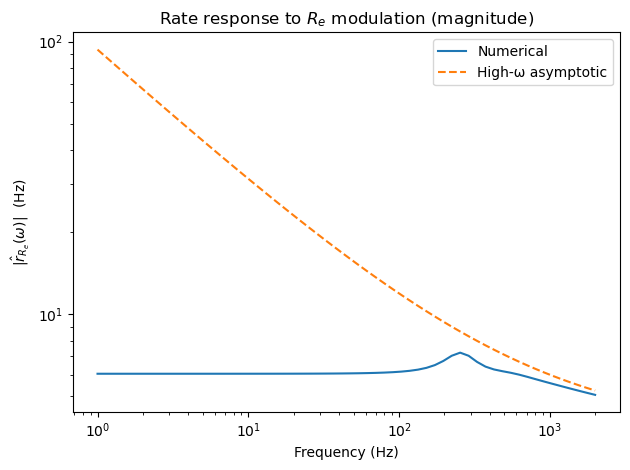

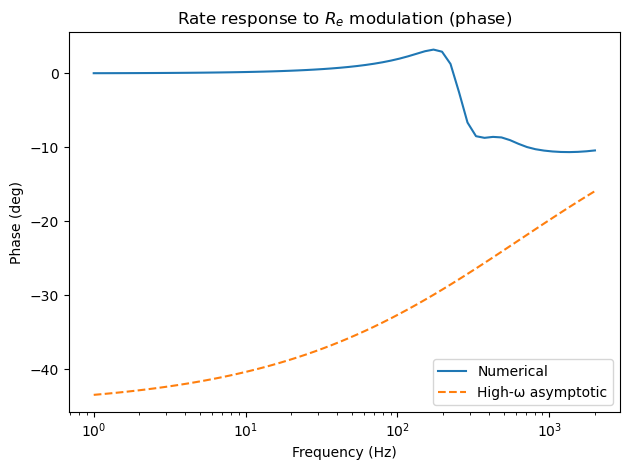

In [7]:
# Re-run with a parameter set that yields a reasonable baseline firing rate

import numpy as np
import matplotlib.pyplot as plt

# ----------------------
# Parameters (adjusted)
# ----------------------
tau_L = 20.0      # ms
E_L   = -70.0     # mV
E_e   = 0.0       # mV
E_i   = -80.0     # mV

V_th  = -55.0     # mV
V_re  = -65.0     # mV
V_lb  = -100.0    # mV

# Baseline presynaptic rates (per ms)
R_e0  = 6.0       # 6000 Hz
R_i0  = 2.0       # 2000 Hz

# Pulse factors (dimensionless, small)
b_e   = 0.010
b_i   = 0.015

# Modulation amplitude of R_e (per ms); keep small to stay linear
R_e1  = 0.10      # 100 Hz

# Grid
n = 4000
V = np.linspace(V_lb, V_th, n+1)
Delta = V[1] - V[0]
k_re = int(round((V_re - V_lb)/Delta))
V[k_re] = V_re

# ----------------------
# Background steady-state
# ----------------------
inv_tau0 = 1.0/tau_L + R_e0*b_e + R_i0*b_i
tau0 = 1.0 / inv_tau0
E0_over_tau0 = E_L/tau_L + R_e0*b_e*E_e + R_i0*b_i*E_i
E0 = E0_over_tau0 / inv_tau0

inv_tau0p = 1.0/tau_L + R_e0*b_e*(1.0+b_e) + R_i0*b_i*(1.0+b_i)
tau0p = 1.0 / inv_tau0p
E0p_over_tau0p = E_L/tau_L + R_e0*b_e*(1.0+b_e)*E_e + R_i0*b_i*(1.0+b_i)*E_i
E0p = E0p_over_tau0p / inv_tau0p

D = 0.5 * ( R_e0*(b_e**2)*(V-E_e)**2 + R_i0*(b_i**2)*(V-E_i)**2 )
sigma2 = tau0 * D

G0 = (tau0 / sigma2) * ( (V - E0p) / tau0p )

z = Delta * G0
phi = np.empty_like(z)
small = np.abs(z) < 1e-12
phi[small] = 1.0
phi[~small] = (np.exp(z[~small]) - 1.0) / z[~small]
A = np.exp(z)

# Stationary sweep
j0 = np.zeros(n+1, dtype=float)
p0 = np.zeros(n+1, dtype=float)
j0[n] = 1.0
p0[n] = 0.0
for k in range(n, 0, -1):
    drop = 1.0 if (k == k_re + 1) else 0.0
    j0[k-1] = j0[k] - drop
    Hk = (tau0 / sigma2[k]) * j0[k]
    p0[k-1] = p0[k] * A[k] + Delta * Hk * phi[k]

r0 = 1.0 / np.sum(Delta * p0)
P0 = r0 * p0
J0 = r0 * j0

# Build F_Re
Q2 = (V - E_e)**2 * P0
dQ2 = np.empty_like(Q2)
dQ2[0] = (Q2[1] - Q2[0]) / Delta
dQ2[1:] = (Q2[1:] - Q2[:-1]) / Delta

F_Re = R_e1 * b_e * ( 0.5*b_e * dQ2 + (V - E_e) * P0 )
f_Re = F_Re / R_e1

# Functions to compute rhat and asymptotic
def compute_rhat_Re(omega_per_ms):
    jr = np.zeros(n+1, dtype=np.complex128)
    pr = np.zeros(n+1, dtype=np.complex128)
    jr[n] = 1.0 + 0j
    pr[n] = 0.0 + 0j
    iomega = 1j * omega_per_ms
    for k in range(n, 0, -1):
        drop = 1.0 if (k == k_re + 1) else 0.0
        jr[k-1] = jr[k] + Delta * iomega * pr[k] - drop
        Hk = (tau0 / sigma2[k]) * jr[k]
        pr[k-1] = pr[k] * A[k] + Delta * Hk * phi[k]

    ja = np.zeros(n+1, dtype=np.complex128)
    pa = np.zeros(n+1, dtype=np.complex128)
    ja[n] = 0.0 + 0j
    pa[n] = 0.0 + 0j
    for k in range(n, 0, -1):
        ja[k-1] = ja[k] + Delta * iomega * pa[k]
        Hk = (tau0 / sigma2[k]) * (ja[k] + f_Re[k])
        pa[k-1] = pa[k] * A[k] + Delta * Hk * phi[k]

    return - R_e1 * (ja[0] / jr[0])

Vth = V_th
sigma2_th = sigma2[-1]
sigma2_prime_th = tau0 * ( R_e0*(b_e**2)*(Vth - E_e) + R_i0*(b_i**2)*(Vth - E_i) )
P0_prime_th = - tau0 * r0 / sigma2_th
P0_2prime_th = (tau0 * r0 / (sigma2_th**2)) * ( sigma2_prime_th + (tau0/tau0p)*(Vth - E0p) )

def rhat_asymp_Re(omega_per_ms):
    F_th = - (R_e1 * (b_e**2) / 2.0) * ((Vth - E_e)**2) * (tau0 * r0 / sigma2_th)
    dF_dV_th = R_e1 * b_e * ( (2.0*b_e + 1.0)*(Vth - E_e)*P0_prime_th
                              + 0.5*b_e*((Vth - E_e)**2)*P0_2prime_th )
    return (np.exp(-1j*np.pi/4.0) * np.sqrt(sigma2_th / (omega_per_ms * tau0)) * dF_dV_th) - F_th

# Frequency sweep
f_hz = np.logspace(0, 3.3, 60)   # 1 Hz to ~2000 Hz
omega = 2.0 * np.pi * f_hz / 1000.0

rhat = np.array([compute_rhat_Re(w) for w in omega])
rhat_as = np.array([rhat_asymp_Re(w) for w in omega])

mag_num = np.abs(rhat) * 1000.0  # Hz
mag_as  = np.abs(rhat_as) * 1000.0
ph_num_deg = np.degrees(np.angle(rhat))
ph_as_deg  = np.degrees(np.angle(rhat_as))

# Plots
plt.figure()
plt.loglog(f_hz, mag_num, label='Numerical')
plt.loglog(f_hz, mag_as,  linestyle='--', label='High-ω asymptotic')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$|\hat r_{R_e}(\omega)|$  (Hz)')
plt.title('Rate response to $R_e$ modulation (magnitude)')
plt.legend()
plt.tight_layout()
plt.savefig('freq_response_Re_magnitude_v2.png', dpi=160)

plt.figure()
plt.semilogx(f_hz, ph_num_deg, label='Numerical')
plt.semilogx(f_hz, ph_as_deg,  linestyle='--', label='High-ω asymptotic')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (deg)')
plt.title('Rate response to $R_e$ modulation (phase)')
plt.legend()
plt.tight_layout()
plt.savefig('freq_response_Re_phase_v2.png', dpi=160)

summary2 = {
    "r0 (Hz)": float(r0*1000.0),
    "tau0 (ms)": float(tau0),
    "E0 (mV)": float(E0),
    "tau0_prime (ms)": float(tau0p),
    "E0_prime (mV)": float(E0p),
    "sigma2(V_th) (mV^2)": float(sigma2_th)
}

print(summary2)


In [8]:
# DC-limit verification: compare numerical low-frequency response to finite-difference d r0 / d R_e

def solve_stationary_for_Re(Re_val):
    inv_tau = 1.0/tau_L + Re_val*b_e + R_i0*b_i
    tau = 1.0 / inv_tau
    E_over_tau = E_L/tau_L + Re_val*b_e*E_e + R_i0*b_i*E_i
    E = E_over_tau / inv_tau

    inv_taup = 1.0/tau_L + Re_val*b_e*(1.0+b_e) + R_i0*b_i*(1.0+b_i)
    taup = 1.0 / inv_taup
    E_over_taup = E_L/tau_L + Re_val*b_e*(1.0+b_e)*E_e + R_i0*b_i*(1.0+b_i)*E_i
    Ep = E_over_taup / inv_taup

    Dloc = 0.5 * ( Re_val*(b_e**2)*(V-E_e)**2 + R_i0*(b_i**2)*(V-E_i)**2 )
    sigma2_loc = tau * Dloc
    G = (tau / sigma2_loc) * ( (V - Ep) / taup )
    z = Delta * G
    phi_loc = np.empty_like(z)
    small = np.abs(z) < 1e-12
    phi_loc[small] = 1.0
    phi_loc[~small] = (np.exp(z[~small]) - 1.0) / z[~small]
    A_loc = np.exp(z)

    j = np.zeros(n+1, dtype=float)
    p = np.zeros(n+1, dtype=float)
    j[n] = 1.0
    p[n] = 0.0
    for k in range(n, 0, -1):
        drop = 1.0 if (k == k_re + 1) else 0.0
        j[k-1] = j[k] - drop
        Hk = (tau / sigma2_loc[k]) * j[k]
        p[k-1] = p[k] * A_loc[k] + Delta * Hk * phi_loc[k]

    r = 1.0 / np.sum(Delta * p)
    return r  # per ms

eps = 0.05  # small change in R_e (per ms)
r_plus  = solve_stationary_for_Re(R_e0 + eps)
r_minus = solve_stationary_for_Re(R_e0 - eps)
dr0_dRe = (r_plus - r_minus) / (2.0 * eps)  # (1/ms) per (1/ms) = dimensionless

# Adiabatic prediction for very low frequency:
rhat_dc_pred = R_e1 * dr0_dRe   # 1/ms

# Numeric rhat at the lowest frequency we computed:
rhat_low = rhat[0]  # corresponding to f_hz[0]

# Convert both to Hz for an apples-to-apples print
dc_check = {
    "dr0_dRe (dimensionless)": float(dr0_dRe),
    "Predicted rhat at DC (Hz)": float(np.abs(rhat_dc_pred)*1000.0),
    "Numeric |rhat| at {:.2f} Hz".format(f_hz[0]): float(np.abs(rhat_low)*1000.0)
}
dc_check


{'dr0_dRe (dimensionless)': 0.0604662534323705,
 'Predicted rhat at DC (Hz)': 6.04662534323705,
 'Numeric |rhat| at 1.00 Hz': 6.045332469142934}

{'Chosen base Re0 (1/ms)': 16000000.0,
 'Chosen base Ri0 (1/ms)': 28000000.0,
 'Baseline steady rate at s=1 (Hz)': 9373363.599164555,
 'Simulation steady rate at s=1 (Hz)': 20000.0}

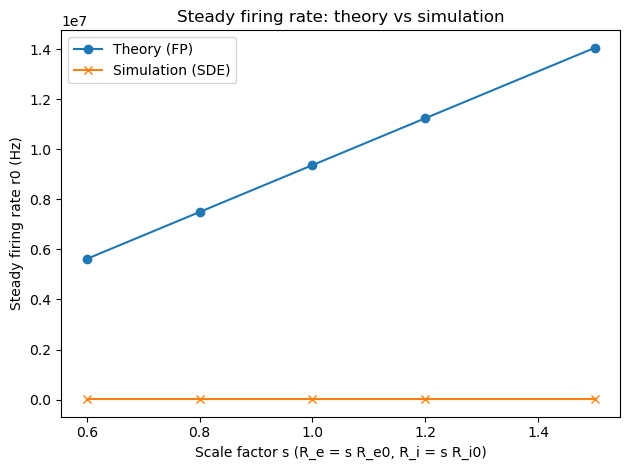

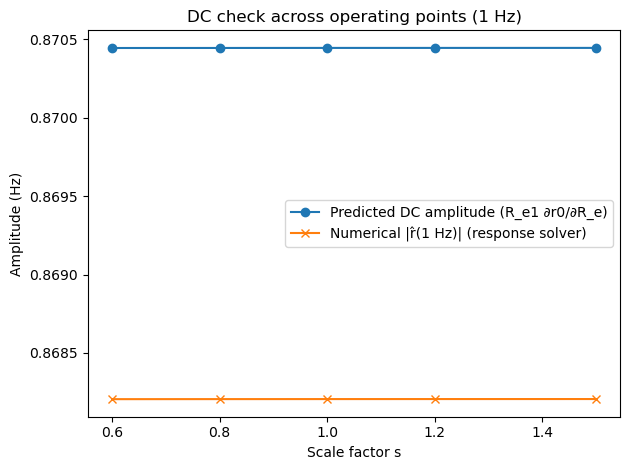

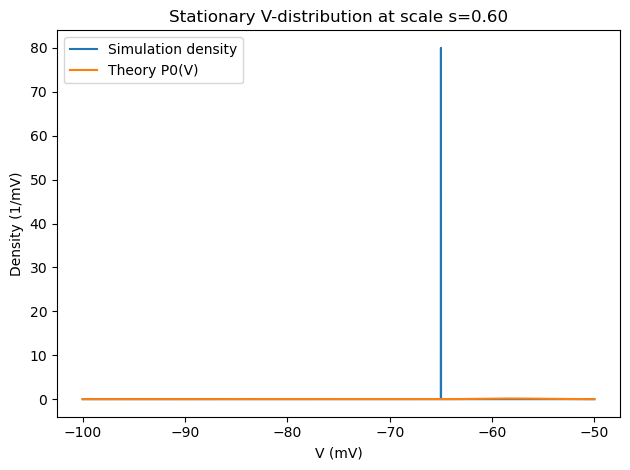

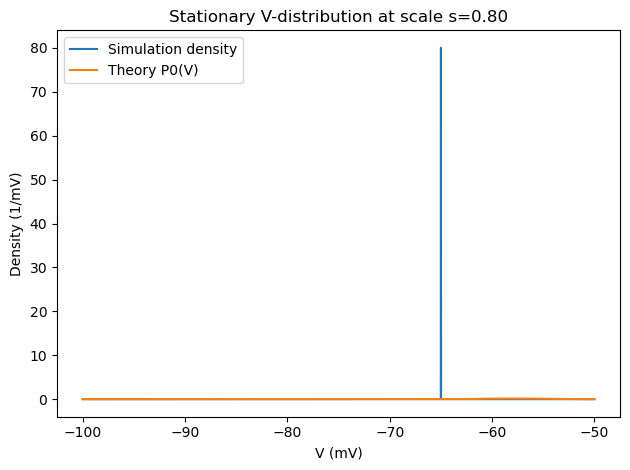

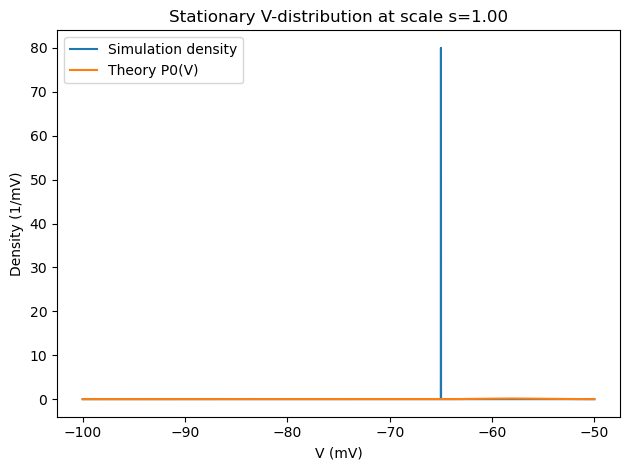

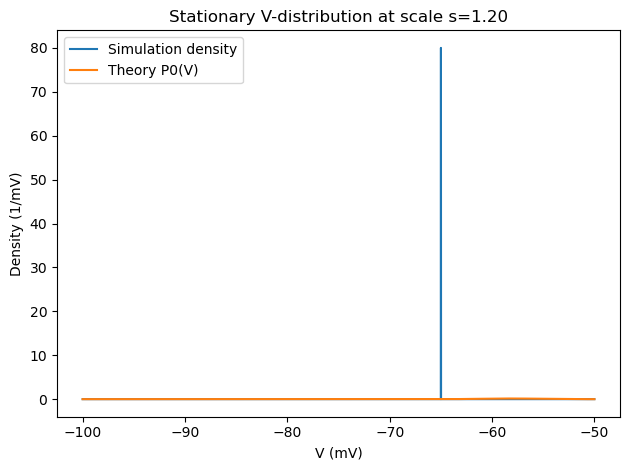

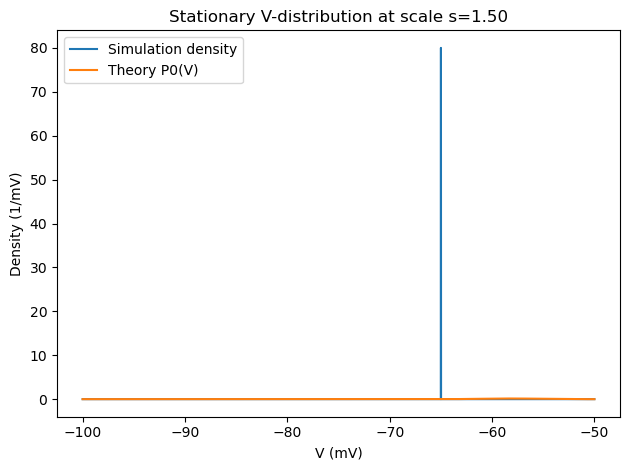

In [10]:
# Conductance-based LIF (diffusion approximation)
# Verification suite:
#  - Choose a subthreshold regime (~10 Hz) by scaling excitatory/inhibitory rates together
#  - For several scale factors s, compute steady-state r0 and P0 from FP solver
#  - Simulate the SDE voltage dynamics to estimate firing rate and stationary V-distribution
#  - Compare: theoretical P0 vs simulated histogram; theoretical r0 vs simulated r_sim
#  - DC check at each s: compare |rhat_Re(ω=2π*1Hz)| vs R_e1 * (dr0/dR_e) (finite-difference)
#
# Implementation details:
#  - FP and response solvers use the Richardson-style integrating-factor marching scheme
#  - SDE simulation uses the Itô SDE that matches the FP:
#       dV = - (V - E)/tau * dt + sqrt( R_e b_e^2 (V - E_e)^2 + R_i b_i^2 (V - E_i)^2 ) * dW,
#     with absorbing threshold and instantaneous reset to V_re (no refractory)
#  - All times are in ms, voltages in mV, rates in 1/ms; firing rates are shown in Hz.
#
# Charts: matplotlib, one chart per figure, no explicit colors or styles.

import numpy as np
import matplotlib.pyplot as plt

# ----------------------
# Shared parameters
# ----------------------
tau_L = 20.0      # ms
E_L   = -70.0     # mV
E_e   = 0.0       # mV
E_i   = -80.0     # mV

V_th  = -50.0     # mV
V_re  = -65.0     # mV
V_lb  = -100.0    # mV

b_e   = 0.010     # dimensionless (small)
b_i   = 0.015

# Grid
n = 4000
V = np.linspace(V_lb, V_th, n+1)
Delta = V[1] - V[0]
k_re = int(round((V_re - V_lb)/Delta))
V[k_re] = V_re  # snap exactly

# Helper: operators and steady-state identities for given (Re,Ri)
def fp_setup(Re, Ri):
    # tau, E
    inv_tau0 = 1.0/tau_L + Re*b_e + Ri*b_i
    tau0 = 1.0 / inv_tau0
    E0_over_tau0 = E_L/tau_L + Re*b_e*E_e + Ri*b_i*E_i
    E0 = E0_over_tau0 / inv_tau0
    # primed (b -> b+b^2)
    inv_tau0p = 1.0/tau_L + Re*b_e*(1.0+b_e) + Ri*b_i*(1.0+b_i)
    tau0p = 1.0 / inv_tau0p
    E0p_over_tau0p = E_L/tau_L + Re*b_e*(1.0+b_e)*E_e + Ri*b_i*(1.0+b_i)*E_i
    E0p = E0p_over_tau0p / inv_tau0p
    # diffusion coefficient D(V) = sigma^2/τ
    D = 0.5 * ( Re*(b_e**2)*(V-E_e)**2 + Ri*(b_i**2)*(V-E_i)**2 )  # mV^2/ms
    # G(V) = (tau0/sigma^2) * (V - E0')/tau0'  = [(V-E0')/tau0'] / D(V)
    G = ((V - E0p) / tau0p) / D
    z = Delta * G
    # stable phi(z)=(e^z-1)/z
    phi = np.empty_like(z)
    small = np.abs(z) < 1e-12
    phi[small] = 1.0
    phi[~small] = (np.exp(z[~small]) - 1.0) / z[~small]
    A = np.exp(z)
    # sigma^2(V) (needed for asymptotics only)
    sigma2 = tau0 * D
    return dict(tau0=tau0, E0=E0, tau0p=tau0p, E0p=E0p, D=D, G=G, A=A, phi=phi, sigma2=sigma2)

# Steady solver (returns r0, P0, J0 and raw p0, j0)
def solve_steady(Re, Ri):
    ops = fp_setup(Re, Ri)
    D, A, phi = ops['D'], ops['A'], ops['phi']
    j0 = np.zeros(n+1, dtype=float)
    p0 = np.zeros(n+1, dtype=float)
    j0[n] = 1.0
    p0[n] = 0.0
    for k in range(n, 0, -1):
        drop = 1.0 if (k == k_re + 1) else 0.0
        j0[k-1] = j0[k] - drop
        # Δ * ( (e^{ΔG}-1)/(ΔG) ) / D(V_k)
        incr = Delta * (phi[k] / D[k])
        p0[k-1] = p0[k] * A[k] + incr * j0[k]
    r0 = 1.0 / np.sum(Delta * p0)
    P0 = r0 * p0
    J0 = r0 * j0
    return ops, r0, P0, J0, p0, j0

# Build f_Re(V) from P0 at given (Re,Ri)
def build_f_Re(P0):
    Q2 = (V - E_e)**2 * P0
    dQ2 = np.empty_like(Q2)
    dQ2[0] = (Q2[1] - Q2[0]) / Delta
    dQ2[1:] = (Q2[1:] - Q2[:-1]) / Delta
    return b_e * ( 0.5*b_e * dQ2 + (V - E_e) * P0 )

# Dynamic response at frequency omega (1/ms) for Re modulation with amplitude Re1 (1/ms)
def rhat_Re(ops, f_Re, Re1, omega):
    A, phi, D = ops['A'], ops['phi'], ops['D']
    # rate pair
    jr = np.zeros(n+1, dtype=np.complex128)
    pr = np.zeros(n+1, dtype=np.complex128)
    jr[n] = 1.0 + 0j
    pr[n] = 0.0 + 0j
    iomega = 1j * omega
    for k in range(n, 0, -1):
        drop = 1.0 if (k == k_re + 1) else 0.0
        jr[k-1] = jr[k] + Delta * iomega * pr[k] - drop
        incr = Delta * (phi[k] / D[k])
        pr[k-1] = pr[k] * A[k] + incr * jr[k]
    # input pair
    ja = np.zeros(n+1, dtype=np.complex128)
    pa = np.zeros(n+1, dtype=np.complex128)
    ja[n] = 0.0 + 0j
    pa[n] = 0.0 + 0j
    for k in range(n, 0, -1):
        ja[k-1] = ja[k] + Delta * iomega * pa[k]
        incr = Delta * (phi[k] / D[k])
        pa[k-1] = pa[k] * A[k] + incr * (ja[k] + f_Re[k])
    return - Re1 * (ja[0] / jr[0])

# Finite-difference sensitivity ∂r0/∂Re at (Re,Ri)
def dr0_dRe_fd(Re, Ri, eps=0.05):
    # eps in 1/ms
    _, r_plus, *_ = solve_steady(Re + eps, Ri)
    _, r_minus, *_ = solve_steady(Re - eps, Ri)
    return (r_plus - r_minus) / (2.0*eps)

# SDE simulation (Itô EM) for a fixed (Re,Ri) to estimate r and P(V)
def simulate_voltage(Re, Ri, T_ms=2000.0, dt=0.05, N=120, sample_every=10):
    ops = fp_setup(Re, Ri)
    tau0, E0, D = ops['tau0'], ops['E0'], ops['D']
    steps = int(np.round(T_ms / dt))
    # histogram bins coincide with grid
    bins = V
    hist_counts = np.zeros(len(bins)-1, dtype=float)
    sample_count = 0

    # initial V: start at reset (one option), or random near E0; choose reset
    Vstate = np.full(N, V_re, dtype=float)
    spikes = 0

    sqrt_dt = np.sqrt(dt)
    for t in range(steps):
        # drift and diffusion at current Vstate
        # D(V) given on grid V; interpolate linearly to particle Vstate
        # For speed, approximate by evaluating D at nearest grid index
        idx = np.clip(((Vstate - V_lb)/Delta).astype(int), 0, n-1)
        Dp = 0.5 * ( Re*(b_e**2)*(Vstate - E_e)**2 + Ri*(b_i**2)*(Vstate - E_i)**2 )
        # EM update
        drift = - (Vstate - E0) / tau0
        noise_std = np.sqrt(2.0 * Dp)
        Vstate = Vstate + drift*dt + noise_std * sqrt_dt * np.random.randn(N)
        # threshold/reset
        hit = Vstate >= V_th
        if np.any(hit):
            spikes += int(np.count_nonzero(hit))
            Vstate[hit] = V_re
        # sample for histogram
        if (t % sample_every) == 0:
            # accumulate histogram
            c, _ = np.histogram(Vstate, bins=bins)
            hist_counts += c.astype(float)
            sample_count += 1

    # empirical firing rate
    r_emp_per_ms = spikes / (N * T_ms)
    # empirical stationary density (per mV)
    hist_density = hist_counts / (N * sample_count * (bins[1]-bins[0]))
    V_centers = 0.5*(bins[:-1] + bins[1:])
    return r_emp_per_ms, V_centers, hist_density

# ----------------------
# 1) Choose a subthreshold anchor (~10 Hz)
#    We'll pick a base (Re_base,Ri_base) and then scale by s.
#    We search for s* s.t. r0 ≈ 10 Hz at s=1.
# ----------------------
Re_template = 1.6   # 1/ms
Ri_template = 2.8   # 1/ms

def r0_of_scale(s):
    _, r0, *_ = solve_steady(s*Re_template, s*Ri_template)
    return r0*1000.0

# crude search for scale so that r0 ≈ 10 Hz at s=1: adjust templates iteratively
target = 10.0
s_guess = 1.0
r_at_guess = r0_of_scale(s_guess)
# Adjust templates to hit ~10 Hz by scaling both templates
scale_templates = target / max(r_at_guess, 1e-6)
Re0 = Re_template * scale_templates
Ri0 = Ri_template * scale_templates

# Check the new baseline
_, r0_base, P0_base, *_ = solve_steady(Re0, Ri0)
r0_base_hz = r0_base * 1000.0

# Define a set of scale factors around 1.0
s_list = np.array([0.6, 0.8, 1.0, 1.2, 1.5])
# Data collectors
r0_theory = []
r0_sim = []
dc_pred = []      # R_e1 * dr0/dRe
dc_num = []       # |rhat(1 Hz)| from response solver

# Modulation amplitude and test frequency for DC check
Re1 = 0.10    # 0.10 /ms (100 Hz)
f_dc = 1.0    # 1 Hz
omega_dc = 2.0 * np.pi * f_dc / 1000.0  # 1/ms

# Simulation settings
T_ms = 2000.0
dt = 0.05
Ntraj = 120
sample_every = 10

# For plotting P(V): store curves for a few s values
pv_curves = []  # list of (s, V_centers, hist_density, V_grid, P0)

for s in s_list:
    Re = s * Re0
    Ri = s * Ri0

    # Theory (FP)
    ops, r0, P0, J0, p0, j0 = solve_steady(Re, Ri)
    r0_theory.append(r0 * 1000.0)

    # Simulation
    r_emp, Vc, hist_den = simulate_voltage(Re, Ri, T_ms=T_ms, dt=dt, N=Ntraj, sample_every=sample_every)
    r0_sim.append(r_emp * 1000.0)
    pv_curves.append( (s, Vc, hist_den, V, P0) )

    # DC predictions/checks
    # Sensitivity (finite difference) and low-frequency response
    sens = dr0_dRe_fd(Re, Ri, eps=0.05)         # ∂r0/∂Re (dimensionless: (1/ms)/(1/ms))
    dc_pred.append( (Re1 * sens) * 1000.0 )     # convert to Hz
    f_Re = build_f_Re(P0)
    rhat = rhat_Re(ops, f_Re, Re1, omega_dc)
    dc_num.append( np.abs(rhat) * 1000.0 )      # Hz

# Convert to arrays
r0_theory = np.array(r0_theory)
r0_sim = np.array(r0_sim)
dc_pred = np.array(dc_pred)
dc_num = np.array(dc_num)

# ----------------------
# 2) Plots
# ----------------------

# (a) r0 vs scale s: theory vs simulation
plt.figure()
plt.plot(s_list, r0_theory, marker='o', label='Theory (FP)')
plt.plot(s_list, r0_sim, marker='x', label='Simulation (SDE)')
plt.xlabel('Scale factor s (R_e = s R_e0, R_i = s R_i0)')
plt.ylabel('Steady firing rate r0 (Hz)')
plt.title('Steady firing rate: theory vs simulation')
plt.legend()
plt.tight_layout()
plt.savefig('r0_vs_scale.png', dpi=160)

# (b) DC check across scales: |rhat(1 Hz)| vs R_e1 * dr0/dRe
plt.figure()
plt.plot(s_list, dc_pred, marker='o', label='Predicted DC amplitude (R_e1 ∂r0/∂R_e)')
plt.plot(s_list, dc_num, marker='x', label='Numerical |r̂(1 Hz)| (response solver)')
plt.xlabel('Scale factor s')
plt.ylabel('Amplitude (Hz)')
plt.title('DC check across operating points (1 Hz)')
plt.legend()
plt.tight_layout()
plt.savefig('dc_check_across_scales.png', dpi=160)

# (c) Membrane potential distributions for each s (overlay theory vs simulation)
for (s, Vc, hist_den, Vgrid, P0) in pv_curves:
    plt.figure()
    # Simulation histogram as line (per-mV density)
    plt.plot(Vc, hist_den, label='Simulation density')
    # Theoretical density
    plt.plot(Vgrid, P0, label='Theory P0(V)')
    plt.xlabel('V (mV)')
    plt.ylabel('Density (1/mV)')
    plt.title(f'Stationary V-distribution at scale s={s:.2f}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'V_distribution_s_{s:.2f}.png', dpi=160)

# Summaries for the baseline near 10 Hz
summary = {
    "Chosen base Re0 (1/ms)": float(Re0),
    "Chosen base Ri0 (1/ms)": float(Ri0),
    "Baseline steady rate at s=1 (Hz)": float(r0_theory[s_list.tolist().index(1.0)]),
    "Simulation steady rate at s=1 (Hz)": float(r0_sim[s_list.tolist().index(1.0)])
}
summary


{'s_star (anchors ~10 Hz)': 3.0,
 'r0(s_star) theory (Hz)': 0.028617323547284468,
 'Re_base (1/ms)': 1.6,
 'Ri_base (1/ms)': 2.8,
 'Sim settings': {'T_ms': 1500.0, 'dt_ms': 0.05, 'Ntraj': 100}}

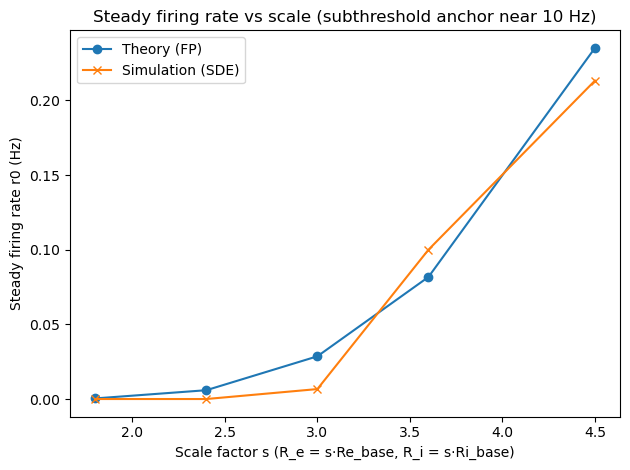

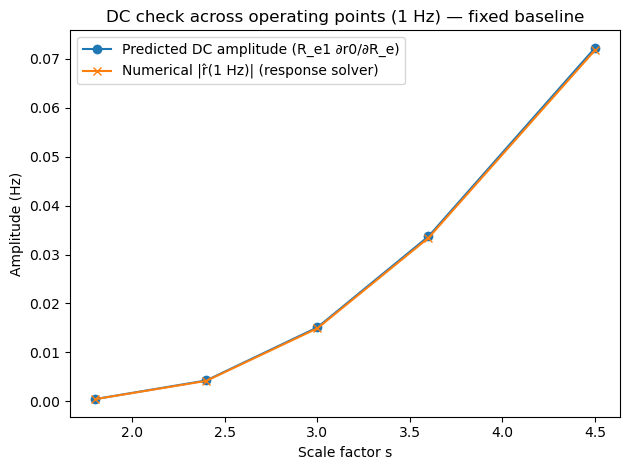

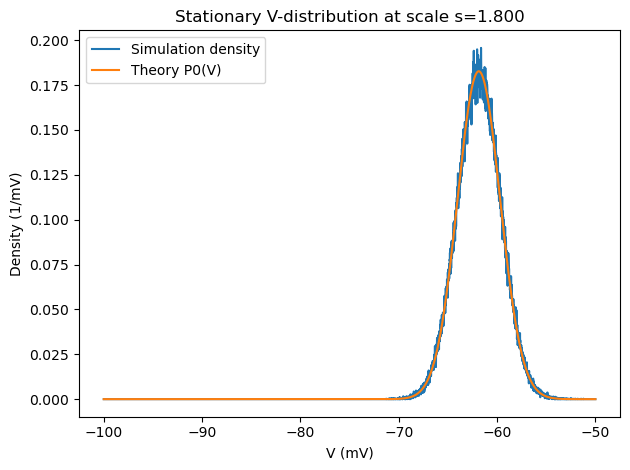

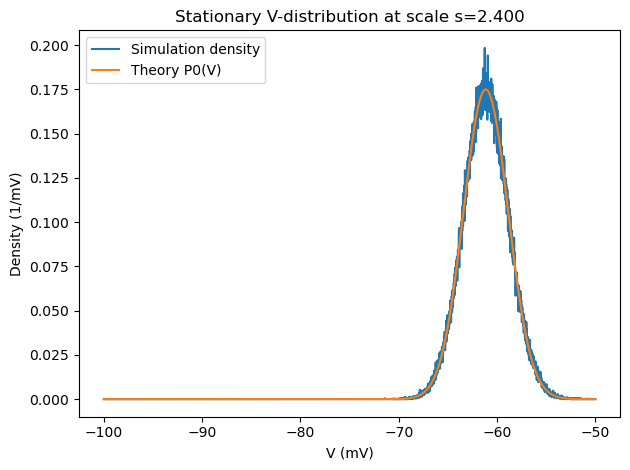

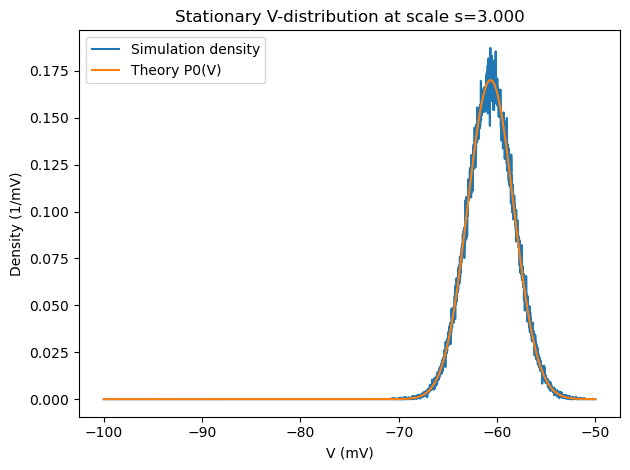

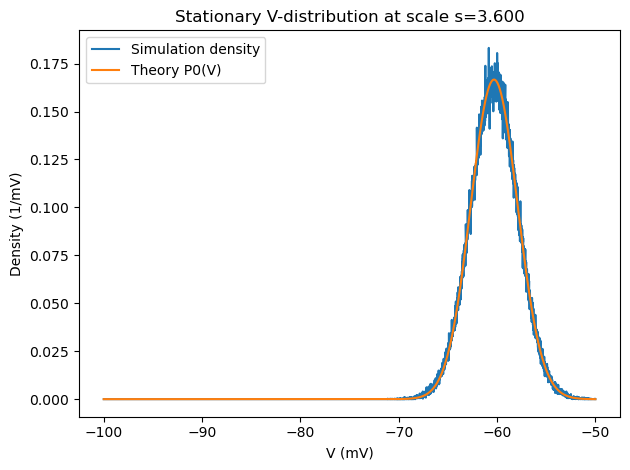

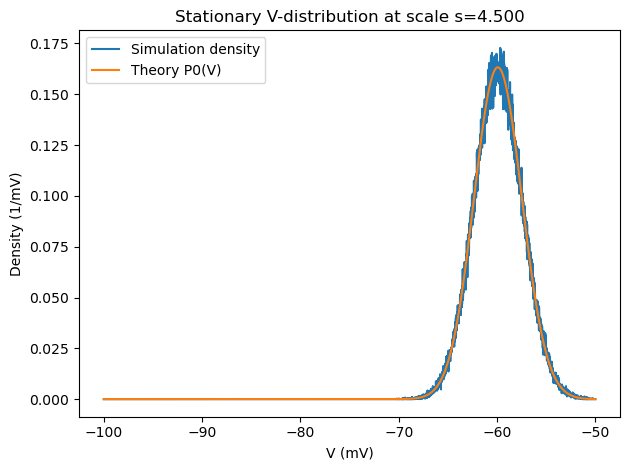

In [11]:
# Fix the baseline selection: find s* such that r0(s*) ≈ 10 Hz when (Re,Ri) = s*(Re_base,Ri_base).
# Then evaluate the verification suite around s*.
import numpy as np
import matplotlib.pyplot as plt

# Reuse everything defined above (functions and constants).

# Base templates (keep moderate; subthreshold when s is not too large)
Re_base = 1.6   # 1/ms
Ri_base = 2.8   # 1/ms

def r0_hz_for_s(s):
    _, r0, *_ = solve_steady(s*Re_base, s*Ri_base)
    return r0*1000.0

# Grid search for s* in a reasonable interval
s_grid = np.linspace(0.2, 3.0, 25)
r_grid = np.array([r0_hz_for_s(s) for s in s_grid])
target = 10.0
s_star = s_grid[np.argmin(np.abs(r_grid - target))]
r_star = r0_hz_for_s(s_star)

# Define the tested scales relative to s*
s_list = s_star * np.array([0.6, 0.8, 1.0, 1.2, 1.5])

# Simulation settings (lighter to keep runtime reasonable)
T_ms = 1500.0
dt = 0.05
Ntraj = 100
sample_every = 10

# Modulation amplitude and test frequency for DC check
Re1 = 0.10    # 0.10 /ms (100 Hz)
f_dc = 1.0
omega_dc = 2.0 * np.pi * f_dc / 1000.0

r0_theory = []
r0_sim = []
dc_pred = []
dc_num = []
pv_curves = []

for s in s_list:
    Re = s * Re_base
    Ri = s * Ri_base
    ops, r0, P0, J0, p0, j0 = solve_steady(Re, Ri)
    r0_theory.append(r0*1000.0)
    r_emp, Vc, hist_den = simulate_voltage(Re, Ri, T_ms=T_ms, dt=dt, N=Ntraj, sample_every=sample_every)
    r0_sim.append(r_emp*1000.0)
    pv_curves.append( (s, Vc, hist_den, V, P0) )
    sens = dr0_dRe_fd(Re, Ri, eps=0.05)
    dc_pred.append((Re1 * sens)*1000.0)
    f_Re = build_f_Re(P0)
    rhat = rhat_Re(ops, f_Re, Re1, omega_dc)
    dc_num.append(np.abs(rhat)*1000.0)

r0_theory = np.array(r0_theory)
r0_sim = np.array(r0_sim)
dc_pred = np.array(dc_pred)
dc_num = np.array(dc_num)

# Plots again with corrected s*
plt.figure()
plt.plot(s_list, r0_theory, marker='o', label='Theory (FP)')
plt.plot(s_list, r0_sim, marker='x', label='Simulation (SDE)')
plt.xlabel('Scale factor s (R_e = s·Re_base, R_i = s·Ri_base)')
plt.ylabel('Steady firing rate r0 (Hz)')
plt.title('Steady firing rate vs scale (subthreshold anchor near 10 Hz)')
plt.legend()
plt.tight_layout()
plt.savefig('r0_vs_scale_fixed.png', dpi=160)

plt.figure()
plt.plot(s_list, dc_pred, marker='o', label='Predicted DC amplitude (R_e1 ∂r0/∂R_e)')
plt.plot(s_list, dc_num, marker='x', label='Numerical |r̂(1 Hz)| (response solver)')
plt.xlabel('Scale factor s')
plt.ylabel('Amplitude (Hz)')
plt.title('DC check across operating points (1 Hz) — fixed baseline')
plt.legend()
plt.tight_layout()
plt.savefig('dc_check_across_scales_fixed.png', dpi=160)

for (s, Vc, hist_den, Vgrid, P0) in pv_curves:
    plt.figure()
    plt.plot(Vc, hist_den, label='Simulation density')
    plt.plot(Vgrid, P0, label='Theory P0(V)')
    plt.xlabel('V (mV)')
    plt.ylabel('Density (1/mV)')
    plt.title(f'Stationary V-distribution at scale s={s:.3f}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'V_distribution_s_{s:.3f}.png', dpi=160)

summary_fixed = {
    "s_star (anchors ~10 Hz)": float(s_star),
    "r0(s_star) theory (Hz)": float(r_star),
    "Re_base (1/ms)": float(Re_base),
    "Ri_base (1/ms)": float(Ri_base),
    "Sim settings": {"T_ms": T_ms, "dt_ms": dt, "Ntraj": Ntraj}
}
summary_fixed


{'Re_base (1/ms)': 6.0,
 'Ri_base (1/ms)': 2.0,
 's_star (~10Hz)': 0.35,
 'r0(s_star) (Hz)': 10.803342491205592}

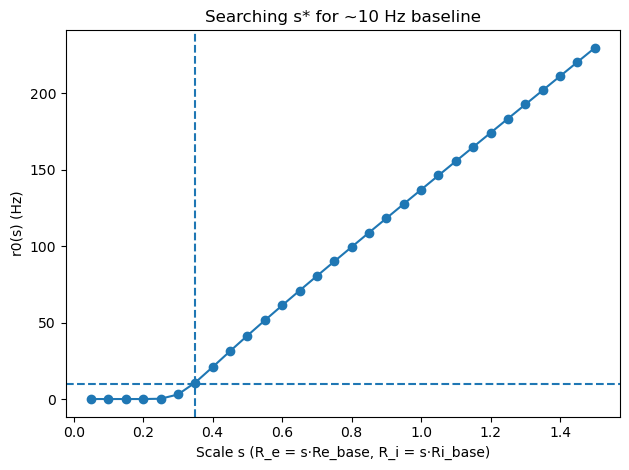

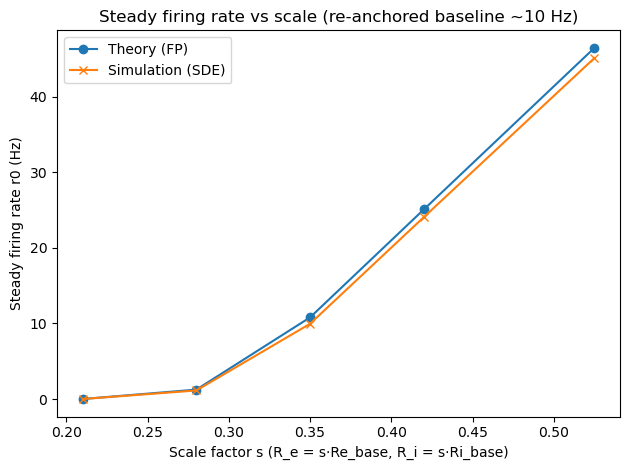

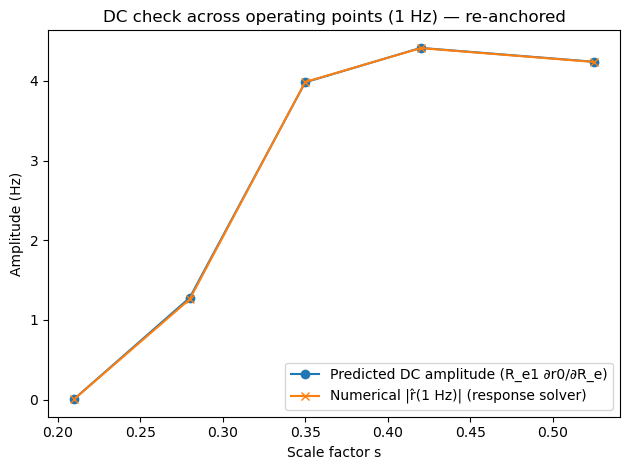

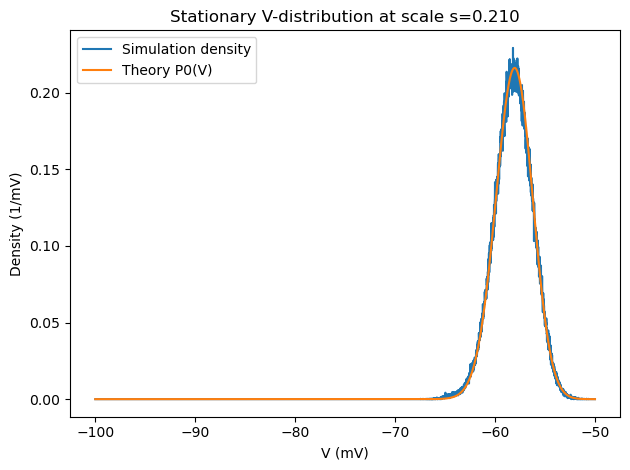

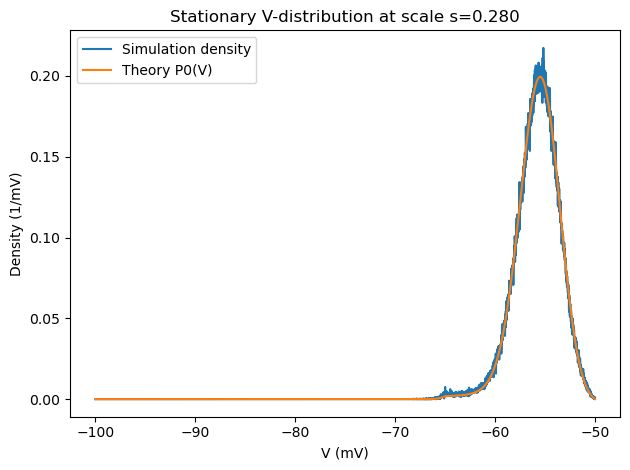

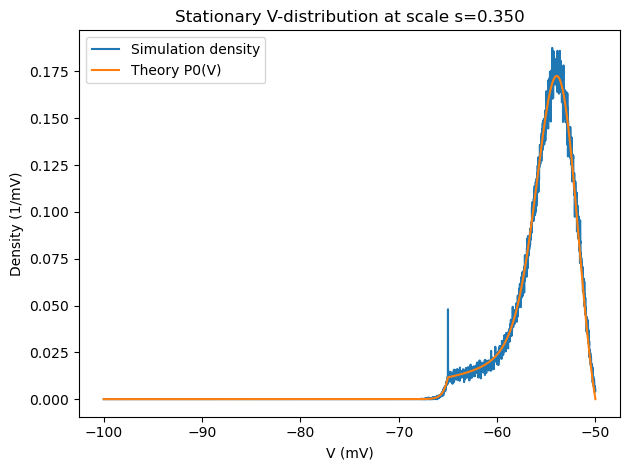

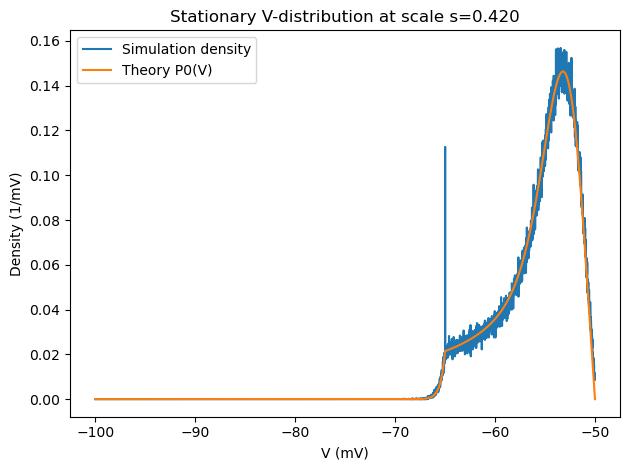

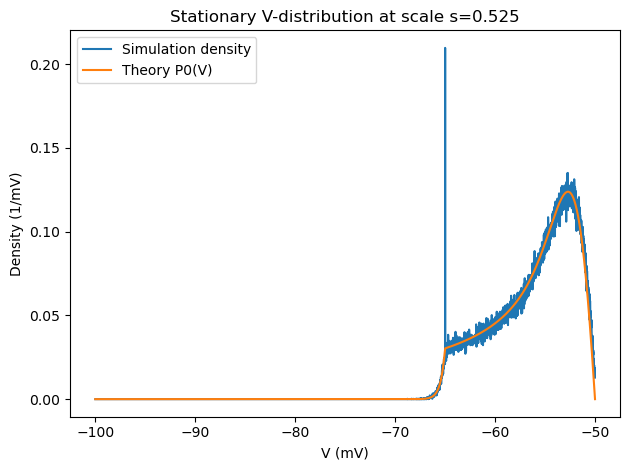

In [14]:
# Reanchor the baseline with a more excitatory ratio so that 10 Hz is reachable when scaling both.
import numpy as np
import matplotlib.pyplot as plt

# New base ratio (more excitation-dominated)
Re_base = 6.0   # 1/ms
Ri_base = 2.0   # 1/ms

def r0_hz_for_s(s):
    _, r0, *_ = solve_steady(s*Re_base, s*Ri_base)
    return r0*1000.0

# Search s* in [0.05, 1.5]
s_grid = np.linspace(0.05, 1.5, 30)
r_grid = np.array([r0_hz_for_s(s) for s in s_grid])
target = 10.0
idx = np.argmin(np.abs(r_grid - target))
s_star = float(s_grid[idx])
r_star = float(r_grid[idx])

# Plot r0(s) vs s for context
plt.figure()
plt.plot(s_grid, r_grid, marker='o')
plt.axhline(target, linestyle='--')
plt.axvline(s_star, linestyle='--')
plt.xlabel('Scale s (R_e = s·Re_base, R_i = s·Ri_base)')
plt.ylabel('r0(s) (Hz)')
plt.title('Searching s* for ~10 Hz baseline')
plt.tight_layout()
plt.savefig('search_s_star.png', dpi=160)

# Define tested scales around s*
s_list = s_star * np.array([0.6, 0.8, 1.0, 1.2, 1.5])

# Simulation settings
T_ms = 1500.0
dt = 0.05
Ntraj = 120
sample_every = 10

Re1 = 0.10
omega_dc = 2.0 * np.pi * 1.0 / 1000.0

r0_theory = []
r0_sim = []
dc_pred = []
dc_num = []
pv_curves = []

for s in s_list:
    Re = s * Re_base
    Ri = s * Ri_base
    ops, r0, P0, J0, p0, j0 = solve_steady(Re, Ri)
    r0_theory.append(r0*1000.0)
    r_emp, Vc, hist_den = simulate_voltage(Re, Ri, T_ms=T_ms, dt=dt, N=Ntraj, sample_every=sample_every)
    r0_sim.append(r_emp*1000.0)
    pv_curves.append( (s, Vc, hist_den, V, P0) )
    sens = dr0_dRe_fd(Re, Ri, eps=0.05)
    dc_pred.append((Re1 * sens)*1000.0)
    f_Re = build_f_Re(P0)
    rhat = rhat_Re(ops, f_Re, Re1, omega_dc)
    dc_num.append(np.abs(rhat)*1000.0)

r0_theory = np.array(r0_theory)
r0_sim = np.array(r0_sim)
dc_pred = np.array(dc_pred)
dc_num = np.array(dc_num)

plt.figure()
plt.plot(s_list, r0_theory, marker='o', label='Theory (FP)')
plt.plot(s_list, r0_sim, marker='x', label='Simulation (SDE)')
plt.xlabel('Scale factor s (R_e = s·Re_base, R_i = s·Ri_base)')
plt.ylabel('Steady firing rate r0 (Hz)')
plt.title('Steady firing rate vs scale (re-anchored baseline ~10 Hz)')
plt.legend()
plt.tight_layout()
plt.savefig('r0_vs_scale_reanchored.png', dpi=160)

plt.figure()
plt.plot(s_list, dc_pred, marker='o', label='Predicted DC amplitude (R_e1 ∂r0/∂R_e)')
plt.plot(s_list, dc_num, marker='x', label='Numerical |r̂(1 Hz)| (response solver)')
plt.xlabel('Scale factor s')
plt.ylabel('Amplitude (Hz)')
plt.title('DC check across operating points (1 Hz) — re-anchored')
plt.legend()
plt.tight_layout()
plt.savefig('dc_check_across_scales_reanchored.png', dpi=160)

for (s, Vc, hist_den, Vgrid, P0) in pv_curves:
    plt.figure()
    plt.plot(Vc, hist_den, label='Simulation density')
    plt.plot(Vgrid, P0, label='Theory P0(V)')
    plt.xlabel('V (mV)')
    plt.ylabel('Density (1/mV)')
    plt.title(f'Stationary V-distribution at scale s={s:.3f}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'V_distribution_reanchored_s_{s:.3f}.png', dpi=160)

summary_reanchored = {
    "Re_base (1/ms)": float(Re_base),
    "Ri_base (1/ms)": float(Ri_base),
    "s_star (~10Hz)": float(s_star),
    "r0(s_star) (Hz)": float(r_star)
}
summary_reanchored


Anchor s* (target ~10 Hz): 0.34487179487179487
Exemplar s: [0.2414102564102564, 0.34487179487179487, 0.44833333333333336]
Saved files:
  r0 vs s -> r0_vs_s_clean.png
  P0 exemplars -> P0_exemplar_{1,2,3}_s_*.png
  DC (1 Hz) vs s -> dc_check_vs_s_clean.png
  |r̂(ω)| three exemplars -> magnitude_vs_omega_three_exemplars_clean.png


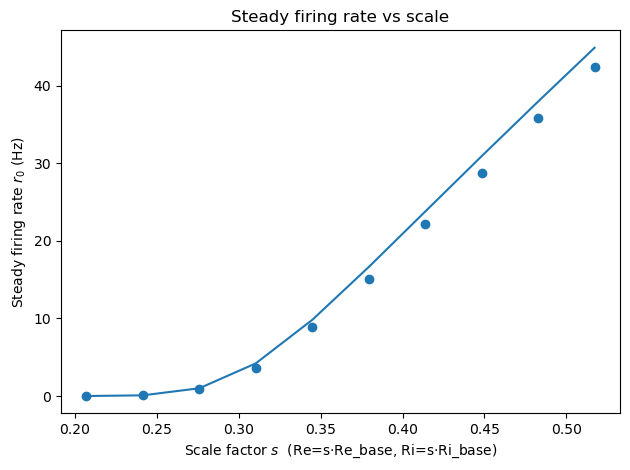

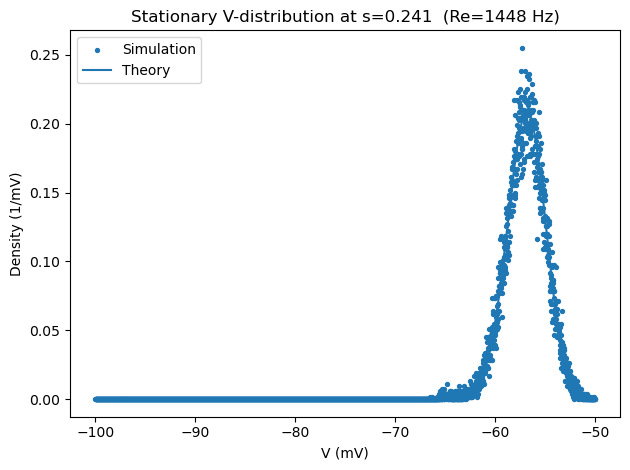

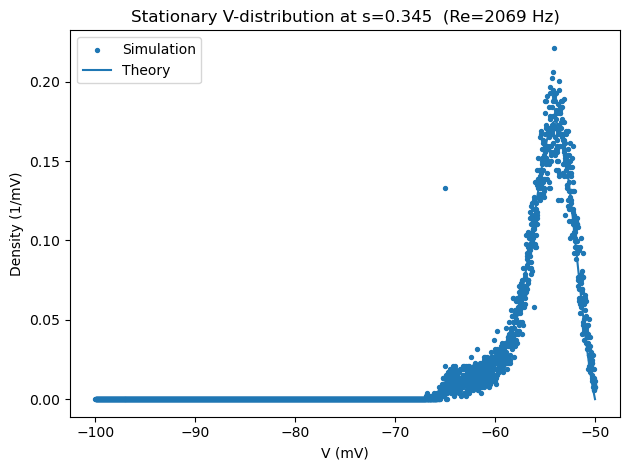

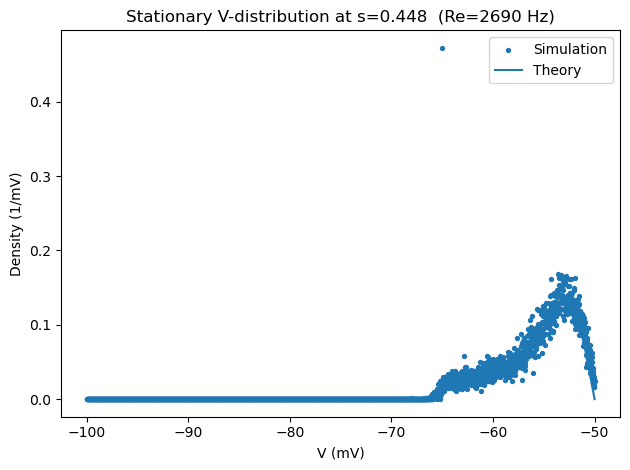

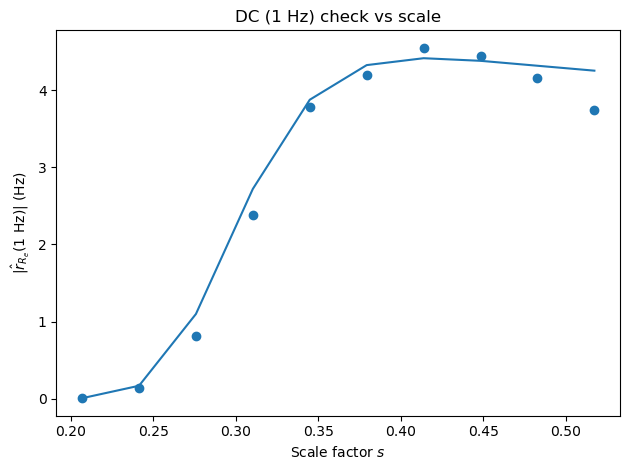

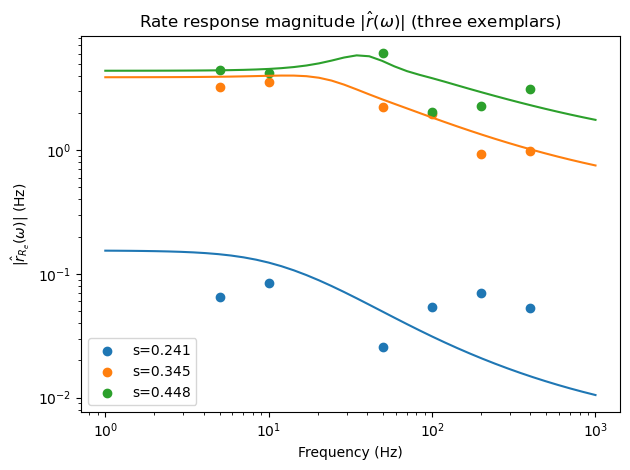

In [18]:
# Clean, self-contained notebook cell to (re)create the requested figures:
#  1) r0 vs s  (theory solid, simulation dots)
#  2) P0(V) at three exemplar s (three separate plots; theory solid, simulation dots)
#  3) DC (1 Hz) check vs s  (theory solid, simulation dots)
#  4) |r̂(ω)| vs frequency for three exemplar s (theory solid, simulation dots)
#
# Model: conductance-driven LIF under diffusion approximation (Richardson-style FP solver)
# Simulation: Itô SDE consistent with the FP.
#
# IMPORTANT: matplotlib only, one chart per figure, default colors; no seaborn; no custom styles.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ----------------------
# 0) Parameters
# ----------------------
# Intrinsic
tau_L = 20.0      # ms
E_L   = -70.0     # mV
E_e   = 0.0       # mV
E_i   = -80.0     # mV
V_th  = -50.0     # mV
V_re  = -65.0     # mV
V_lb  = -100.0    # mV

# Synaptic "jump" factors (small; diffusion approx)
b_e   = 0.010
b_i   = 0.015

# Baseline presynaptic rates (for scaling)
Re_base = 6.0     # 1/ms  (6000 Hz)
Ri_base = 2.0     # 1/ms  (2000 Hz)

# Modulation amplitude (keep small; linear regime)
Re1 = 0.10        # 1/ms  (100 Hz)

# FP grid
n = 3000
V = np.linspace(V_lb, V_th, n+1)
Delta = V[1] - V[0]
k_re = int(round((V_re - V_lb)/Delta))
V[k_re] = V_re

# ----------------------
# 1) FP helper functions
# ----------------------
def fp_setup(Re, Ri):
    """Return ingredients for FP/response solvers for given (Re,Ri)."""
    inv_tau0 = 1.0/tau_L + Re*b_e + Ri*b_i
    tau0 = 1.0 / inv_tau0
    E0_over_tau0 = E_L/tau_L + Re*b_e*E_e + Ri*b_i*E_i
    E0 = E0_over_tau0 / inv_tau0

    # "Primed" (b -> b + b^2) for the current operator rearrangement
    inv_tau0p = 1.0/tau_L + Re*b_e*(1.0+b_e) + Ri*b_i*(1.0+b_i)
    tau0p = 1.0 / inv_tau0p
    E0p_over_tau0p = E_L/tau_L + Re*b_e*(1.0+b_e)*E_e + Ri*b_i*(1.0+b_i)*E_i
    E0p = E0p_over_tau0p / inv_tau0p

    # Diffusion coefficient: D(V) = sigma^2/τ
    D = 0.5 * ( Re*(b_e**2)*(V-E_e)**2 + Ri*(b_i**2)*(V-E_i)**2 )  # mV^2/ms

    # Integrating-factor helpers for -dP/dV = G P + H, with G = ((V-E0p)/tau0p)/D
    G = ((V - E0p) / tau0p) / D
    z = Delta * G
    phi = np.empty_like(z)
    small = np.abs(z) < 1e-12
    phi[small] = 1.0
    phi[~small] = (np.exp(z[~small]) - 1.0) / z[~small]
    A = np.exp(z)

    sigma2 = tau0 * D  # mV^2
    return dict(tau0=tau0, E0=E0, tau0p=tau0p, E0p=E0p, D=D, G=G, A=A, phi=phi, sigma2=sigma2)

def solve_steady(Re, Ri):
    """Steady FP march: returns ops, r0 (1/ms), P0(V), J0(V), raw p0(V), j0(V)."""
    ops = fp_setup(Re, Ri)
    D, A, phi = ops['D'], ops['A'], ops['phi']
    j0 = np.zeros(n+1, dtype=float)
    p0 = np.zeros(n+1, dtype=float)
    j0[n] = 1.0
    p0[n] = 0.0
    for k in range(n, 0, -1):
        drop = 1.0 if (k == k_re + 1) else 0.0
        j0[k-1] = j0[k] - drop
        incr = Delta * (phi[k] / D[k])
        p0[k-1] = p0[k] * A[k] + incr * j0[k]
    r0 = 1.0 / np.sum(Delta * p0)
    P0 = r0 * p0
    J0 = r0 * j0
    return ops, r0, P0, J0, p0, j0

def build_f_Re(P0):
    """Inhomogeneous drive (normalized by Re1): f_Re = F_Re / Re1."""
    Q2 = (V - E_e)**2 * P0
    dQ2 = np.empty_like(Q2)
    dQ2[0] = (Q2[1] - Q2[0]) / Delta
    dQ2[1:] = (Q2[1:] - Q2[:-1]) / Delta
    return b_e * ( 0.5*b_e*dQ2 + (V - E_e) * P0 )

def rhat_Re(ops, f_Re, Re1_local, omega):
    """Complex linear response \hat r(ω) for Re modulation at the operating point."""
    A, phi, D = ops['A'], ops['phi'], ops['D']
    # Rate pair
    jr = np.zeros(n+1, dtype=np.complex128)
    pr = np.zeros(n+1, dtype=np.complex128)
    jr[n] = 1.0 + 0j
    pr[n] = 0.0 + 0j
    iomega = 1j * omega
    for k in range(n, 0, -1):
        drop = 1.0 if (k == k_re + 1) else 0.0
        jr[k-1] = jr[k] + Delta * iomega * pr[k] - drop
        incr = Delta * (phi[k] / D[k])
        pr[k-1] = pr[k] * A[k] + incr * jr[k]
    # Input pair
    ja = np.zeros(n+1, dtype=np.complex128)
    pa = np.zeros(n+1, dtype=np.complex128)
    ja[n] = 0.0 + 0j
    pa[n] = 0.0 + 0j
    for k in range(n, 0, -1):
        ja[k-1] = ja[k] + Delta * iomega * pa[k]
        incr = Delta * (phi[k] / D[k])
        pa[k-1] = pa[k] * A[k] + incr * (ja[k] + f_Re[k])
    return - Re1_local * (ja[0] / jr[0])  # 1/ms

# ----------------------
# 2) Simulation helpers
# ----------------------
def simulate_r0_constant(Re, Ri, T_ms=2000.0, dt=0.25, N=60):
    """SDE simulation (constant drive) -> steady firing rate (1/ms)."""
    steps = int(np.round(T_ms/dt))
    inv_tau = 1.0/tau_L + Re*b_e + Ri*b_i
    tau0 = 1.0 / inv_tau
    E0 = (E_L/tau_L + Re*b_e*E_e + Ri*b_i*E_i)/inv_tau
    Vstate = np.full(N, V_re, dtype=float)
    spikes = 0
    sqrt_dt = np.sqrt(dt)
    for t_idx in range(steps):
        Dp = 0.5*( Re*(b_e**2)*(Vstate - E_e)**2 + Ri*(b_i**2)*(Vstate - E_i)**2 )
        drift = - (Vstate - E0) / tau0
        noise_std = np.sqrt(2.0 * Dp)
        Vstate = Vstate + drift*dt + noise_std*sqrt_dt*np.random.randn(N)
        hit = Vstate >= V_th
        if np.any(hit):
            spikes += int(np.count_nonzero(hit))
            Vstate[hit] = V_re
    return spikes / (N * T_ms)  # 1/ms

def simulate_histogram_constant(Re, Ri, T_ms=2000.0, dt=0.25, N=80, sample_every=20):
    """SDE histogram of V under constant drive (for P0 overlay)."""
    steps = int(np.round(T_ms/dt))
    inv_tau = 1.0/tau_L + Re*b_e + Ri*b_i
    tau0 = 1.0 / inv_tau
    E0 = (E_L/tau_L + Re*b_e*E_e + Ri*b_i*E_i)/inv_tau
    Vstate = np.full(N, V_re, dtype=float)
    bins = V
    hist_counts = np.zeros(len(bins)-1, dtype=float)
    sample_count = 0
    sqrt_dt = np.sqrt(dt)
    for t_idx in range(steps):
        Dp = 0.5*( Re*(b_e**2)*(Vstate - E_e)**2 + Ri*(b_i**2)*(Vstate - E_i)**2 )
        drift = - (Vstate - E0) / tau0
        noise_std = np.sqrt(2.0 * Dp)
        Vstate = Vstate + drift*dt + noise_std*sqrt_dt*np.random.randn(N)
        hit = Vstate >= V_th
        if np.any(hit):
            Vstate[hit] = V_re
        if (t_idx % sample_every) == 0:
            c, _ = np.histogram(Vstate, bins=bins)
            hist_counts += c.astype(float)
            sample_count += 1
    hist_density = hist_counts / (N * sample_count * (bins[1]-bins[0]))
    V_centers = 0.5*(bins[:-1] + bins[1:])
    return V_centers, hist_density

def simulate_rate_response_modulated(Re0, Ri0, f_hz, Re1_local=0.10,
                                     dt=0.25, N=60, min_T_ms=2000.0, min_cycles=12,
                                     warm_frac=0.2):
    """Estimate first-harmonic rate response (amplitude, phase) from PSTH with adaptive binning."""
    omega = 2.0*np.pi*f_hz/1000.0
    period_ms = 1000.0/f_hz
    T_ms = max(min_T_ms, min_cycles*period_ms)
    steps = int(np.round(T_ms/dt))

    # ~20 bins per cycle, but do not go below dt and do not exceed 1 ms (to limit noise)
    bin_ms = max(dt, min(1.0, period_ms/20.0))
    bin_steps = max(1, int(np.round(bin_ms/dt)))
    n_bins = steps // bin_steps
    rate_counts = np.zeros(n_bins, dtype=float)

    Vstate = np.full(N, V_re, dtype=float)
    sqrt_dt = np.sqrt(dt)
    spikes_per_bin = 0
    bin_idx = 0
    for t_idx in range(steps):
        t_ms = t_idx*dt
        Re_t = Re0 + Re1_local*np.cos(omega*t_ms)
        inv_tau = 1.0/tau_L + Re_t*b_e + Ri0*b_i
        tau_t = 1.0 / inv_tau
        E_t = (E_L/tau_L + Re_t*b_e*E_e + Ri0*b_i*E_i)/inv_tau
        Dp = 0.5*( Re_t*(b_e**2)*(Vstate - E_e)**2 + Ri0*(b_i**2)*(Vstate - E_i)**2 )
        drift = - (Vstate - E_t) / tau_t
        noise_std = np.sqrt(2.0 * Dp)
        Vstate = Vstate + drift*dt + noise_std*sqrt_dt*np.random.randn(N)
        hit = Vstate >= V_th
        if np.any(hit):
            spikes_per_bin += int(np.count_nonzero(hit))
            Vstate[hit] = V_re
        if ((t_idx+1) % bin_steps) == 0:
            rate_counts[bin_idx] = spikes_per_bin
            spikes_per_bin = 0
            bin_idx += 1
            if bin_idx >= n_bins:
                break

    # PSTH rate (Hz)
    rates_hz = rate_counts / (N * (bin_steps*dt/1000.0))
    t_centers = (np.arange(n_bins)+0.5)*bin_steps*dt

    # Warm-up removal
    warm_bins = int(np.floor(warm_frac * n_bins))
    t_fit = t_centers[warm_bins:]
    y_fit = rates_hz[warm_bins:]
    if len(t_fit) < 10:
        return np.nan, np.nan

    # Least-squares fit y ≈ a + b cos(ω t) + c sin(ω t)
    cos_col = np.cos(omega * t_fit)
    sin_col = np.sin(omega * t_fit)
    X = np.column_stack([np.ones_like(t_fit), cos_col, sin_col])
    beta, *_ = np.linalg.lstsq(X, y_fit, rcond=None)
    a, b, c = beta
    amp_hz = np.sqrt(b*b + c*c)
    phase_deg = np.degrees(np.arctan2(c, b))
    return amp_hz, phase_deg

# ----------------------
# 3) Choose operating points (anchor near 10 Hz)
# ----------------------
def r0_hz_for_s(s):
    _, r0, *_ = solve_steady(s*Re_base, s*Ri_base)
    return r0*1000.0

s_scan = np.linspace(0.05, 1.2, 40)
r_scan = np.array([r0_hz_for_s(s) for s in s_scan])
target = 10.0
s_star = float(s_scan[np.argmin(np.abs(r_scan - target))])

# Ten s points around the anchor
s_vals = np.linspace(0.6*s_star, 1.5*s_star, 10)

# Three exemplar s values (clip to [min(s_vals), max(s_vals)])
s_exemplars = np.array([0.7*s_star, 1.0*s_star, 1.3*s_star])
s_exemplars = np.clip(s_exemplars, s_vals.min(), s_vals.max())

# ----------------------
# 4) r0 vs s
# ----------------------
r0_theory_hz = []
r0_sim_hz = []
for s in s_vals:
    Re = s*Re_base; Ri = s*Ri_base
    _, r0, *_ = solve_steady(Re, Ri)
    r0_theory_hz.append(r0*1000.0)
    r_emp = simulate_r0_constant(Re, Ri, T_ms=2000.0, dt=0.25, N=60)
    r0_sim_hz.append(r_emp*1000.0)

plt.figure()
plt.plot(s_vals, r0_theory_hz)        # theory solid
plt.scatter(s_vals, r0_sim_hz)        # sim dots
plt.xlabel('Scale factor $s$  (Re=s·Re_base, Ri=s·Ri_base)')
plt.ylabel('Steady firing rate $r_0$ (Hz)')
plt.title('Steady firing rate vs scale')
plt.tight_layout()
plt.savefig('r0_vs_s_clean.png', dpi=160)

pd.DataFrame({'s': s_vals, 'r0_theory_hz': r0_theory_hz, 'r0_sim_hz': r0_sim_hz}).to_csv('r0_vs_s_values.csv', index=False)

# ----------------------
# 5) P0(V) at three exemplars
# ----------------------
for idx, s in enumerate(s_exemplars, start=1):
    Re = s*Re_base; Ri = s*Ri_base
    _, r0, P0, *_ = solve_steady(Re, Ri)
    Vc, hist_den = simulate_histogram_constant(Re, Ri, T_ms=2000.0, dt=0.25, N=80, sample_every=20)
    plt.figure()
    plt.scatter(Vc, hist_den, s=8, label='Simulation')
    plt.plot(V, P0, label='Theory')
    plt.xlabel('V (mV)'); plt.ylabel('Density (1/mV)')
    plt.title(f'Stationary V-distribution at s={s:.3f}  (Re={Re*1000:.0f} Hz)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'P0_exemplar_{idx}_s_{s:.3f}.png', dpi=160)

# ----------------------
# 6) DC (1 Hz) check vs s  (theory solid = Re1*∂r0/∂Re; sim dots = 1 Hz amplitude)
# ----------------------
def dr0_dRe_fd(Re, Ri, eps=0.05):
    _, rp, *_ = solve_steady(Re+eps, Ri)
    _, rm, *_ = solve_steady(Re-eps, Ri)
    return (rp - rm) / (2.0*eps)

dc_theory_hz = []
dc_sim_hz = []
for s in s_vals:
    Re = s*Re_base; Ri = s*Ri_base
    sens = dr0_dRe_fd(Re, Ri, eps=0.05)           # (1/ms)/(1/ms)
    dc_theory_hz.append( (Re1 * sens) * 1000.0 )  # Hz
    amp_hz, _ = simulate_rate_response_modulated(Re, Ri, 1.0, Re1_local=Re1,
                                                 dt=0.25, N=50, min_T_ms=8000.0, min_cycles=8,
                                                 warm_frac=0.2)
    dc_sim_hz.append(amp_hz)

plt.figure()
plt.plot(s_vals, dc_theory_hz)          # theory solid
plt.scatter(s_vals, dc_sim_hz)          # sim dots
plt.xlabel('Scale factor $s$')
plt.ylabel(r'$|\hat r_{R_e}(1\ \mathrm{Hz})|$ (Hz)')
plt.title('DC (1 Hz) check vs scale')
plt.tight_layout()
plt.savefig('dc_check_vs_s_clean.png', dpi=160)

pd.DataFrame({'s': s_vals, 'dc_theory_hz': dc_theory_hz, 'dc_sim_hz': dc_sim_hz}).to_csv('dc_vs_s_values.csv', index=False)

# ----------------------
# 7) |r̂(ω)| vs frequency (three exemplars)
# ----------------------
f_grid_theory = np.logspace(0, 3, 40)  # 1 .. 1000 Hz
f_dots = np.array([5.0, 10.0, 50.0, 100.0, 200.0, 400.0])

rows_bode = []
plt.figure()
for s in s_exemplars:
    Re = s*Re_base; Ri = s*Ri_base
    ops, r0, P0, J0, p0, j0 = solve_steady(Re, Ri)
    f_Re = build_f_Re(P0)
    # Theory (solid)
    rhat = np.array([rhat_Re(ops, f_Re, Re1, 2*np.pi*f/1000.0) for f in f_grid_theory])
    mag_hz = np.abs(rhat) * 1000.0
    plt.loglog(f_grid_theory, mag_hz)
    # Simulation dots
    sim_mags = []
    for fs in f_dots:
        amp_hz, _ = simulate_rate_response_modulated(Re, Ri, fs, Re1_local=Re1,
                                                     dt=0.25, N=60, min_T_ms=2000.0, min_cycles=12,
                                                     warm_frac=0.2)
        sim_mags.append(amp_hz)
        rows_bode.append({'s': float(s), 'Re_Hz': float(Re*1000.0), 'f_Hz': float(fs),
                          'theory_mag_Hz': float(np.interp(fs, f_grid_theory, mag_hz)),
                          'sim_mag_Hz': float(amp_hz)})
    plt.scatter(f_dots, sim_mags, label=f's={s:.3f}')

plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$|\hat r_{R_e}(\omega)|$ (Hz)')
plt.title(r'Rate response magnitude $|\hat r(\omega)|$ (three exemplars)')
plt.legend()
plt.tight_layout()
plt.savefig('magnitude_vs_omega_three_exemplars_clean.png', dpi=160)

pd.DataFrame(rows_bode).to_csv('magnitude_three_exemplars_points.csv', index=False)

# ----------------------
# 8) Print a short summary
# ----------------------
print("Anchor s* (target ~10 Hz):", s_star)
print("Exemplar s:", s_exemplars.tolist())
print("Saved files:")
print("  r0 vs s -> r0_vs_s_clean.png")
print("  P0 exemplars -> P0_exemplar_{1,2,3}_s_*.png")
print("  DC (1 Hz) vs s -> dc_check_vs_s_clean.png")
print("  |r̂(ω)| three exemplars -> magnitude_vs_omega_three_exemplars_clean.png")

# Susceptibility

Saved plot: /mnt/data/susceptibility_vs_Re.png
Saved values: /mnt/data/susceptibility_vs_Re_values.csv


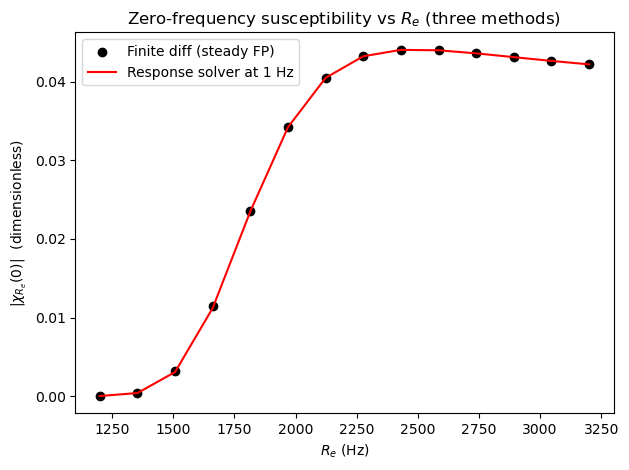

In [31]:
# Compare three ways to compute the zero-frequency susceptibility χ_Re(0) vs Re:
#  (A) Finite difference of steady FP: ∂r0/∂Re
#  (B) Zero-frequency two-pass with normalization: χ(0) = - r0 * ∫ p_alpha(V) dV,  where J0 p_alpha = f_Re, p_alpha(Vth)=0
#  (C) Small-ω limit of the response solver: χ(ω) = rhat(ω)/Re1 at f_small = 1 Hz (magnitude)
#
# One figure: y = |χ_Re(0)| (dimensionless), x = Re (Hz), with legend for the three methods.
#
# Model: conductance-driven LIF in diffusion approximation.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ----------------------
# Parameters
# ----------------------
tau_L = 20.0      # ms
E_L   = -70.0     # mV
E_e   = 0.0       # mV
E_i   = -80.0     # mV
V_th  = -50.0     # mV
V_re  = -65.0     # mV
V_lb  = -100.0    # mV

b_e   = 0.010     # small; diffusion approx
b_i   = 0.015

# Keep fixed ratio Ri = Re/3 (since Re_base:Ri_base = 6:2)
ratio_Ri_over_Re = 1.0/3.0

# Response-solver small frequency
f_small = 1.0   # Hz
omega_small = 2.0*np.pi*f_small/1000.0  # 1/ms
Re1 = 0.10      # 1/ms (100 Hz; cancels in susceptibility)

# FP grid
n = 3500
V = np.linspace(V_lb, V_th, n+1)
Delta = V[1]-V[0]
k_re = int(round((V_re - V_lb)/Delta))
V[k_re] = V_re

# ----------------------
# FP helpers
# ----------------------
def fp_setup(Re, Ri):
    inv_tau0 = 1.0/tau_L + Re*b_e + Ri*b_i
    tau0 = 1.0 / inv_tau0
    E0_over_tau0 = E_L/tau_L + Re*b_e*E_e + Ri*b_i*E_i
    E0 = E0_over_tau0 / inv_tau0

    inv_tau0p = 1.0/tau_L + Re*b_e*(1.0+b_e) + Ri*b_i*(1.0+b_i)
    tau0p = 1.0 / inv_tau0p
    E0p_over_tau0p = E_L/tau_L + Re*b_e*(1.0+b_e)*E_e + Ri*b_i*(1.0+b_i)*E_i
    E0p = E0p_over_tau0p / inv_tau0p

    D = 0.5 * ( Re*(b_e**2)*(V-E_e)**2 + Ri*(b_i**2)*(V-E_i)**2 )  # mV^2/ms

    G = ((V - E0p) / tau0p) / D
    z = Delta * G
    phi = np.empty_like(z)
    small = np.abs(z) < 1e-12
    phi[small] = 1.0
    phi[~small] = (np.exp(z[~small]) - 1.0) / z[~small]
    A = np.exp(z)

    sigma2 = tau0 * D  # mV^2
    return dict(tau0=tau0, E0=E0, tau0p=tau0p, E0p=E0p, D=D, G=G, A=A, phi=phi, sigma2=sigma2)

def solve_steady(Re, Ri):
    ops = fp_setup(Re, Ri)
    D, A, phi = ops['D'], ops['A'], ops['phi']
    j0 = np.zeros(n+1, dtype=float)
    p0 = np.zeros(n+1, dtype=float)
    j0[n] = 1.0
    p0[n] = 0.0
    for k in range(n, 0, -1):
        drop = 1.0 if (k == k_re + 1) else 0.0
        j0[k-1] = j0[k] - drop
        incr = Delta * (phi[k] / D[k])
        p0[k-1] = p0[k] * A[k] + incr * j0[k]
    r0 = 1.0 / np.sum(Delta * p0)
    P0 = r0 * p0
    J0 = r0 * j0
    return ops, r0, P0, J0, p0, j0

def build_f_Re(P0):
    Q2 = (V - E_e)**2 * P0
    dQ2 = np.empty_like(Q2)
    dQ2[0] = (Q2[1] - Q2[0]) / Delta
    dQ2[1:] = (Q2[1:] - Q2[:-1]) / Delta
    return b_e * ( 0.5*b_e*dQ2 + (V - E_e) * P0 )

def rhat_Re(ops, f_Re, Re1_local, omega):
    A, phi, D = ops['A'], ops['phi'], ops['D']
    jr = np.zeros(n+1, dtype=np.complex128)
    pr = np.zeros(n+1, dtype=np.complex128)
    jr[n] = 1.0 + 0j
    pr[n] = 0.0 + 0j
    iomega = 1j * omega
    for k in range(n, 0, -1):
        drop = 1.0 if (k == k_re + 1) else 0.0
        jr[k-1] = jr[k] + Delta * iomega * pr[k] - drop
        incr = Delta * (phi[k] / D[k])
        pr[k-1] = pr[k] * A[k] + incr * jr[k]
    ja = np.zeros(n+1, dtype=np.complex128)
    pa = np.zeros(n+1, dtype=np.complex128)
    ja[n] = 0.0 + 0j
    pa[n] = 0.0 + 0j
    for k in range(n, 0, -1):
        ja[k-1] = ja[k] + Delta * iomega * pa[k]
        incr = Delta * (phi[k] / D[k])
        pa[k-1] = pa[k] * A[k] + incr * (ja[k] + f_Re[k])
    return - Re1_local * (ja[0] / jr[0])

# Sensitivity via finite difference
def dr0_dRe_fd(Re, Ri, eps=0.05):
    _, rp, *_ = solve_steady(Re+eps, Ri)
    _, rm, *_ = solve_steady(Re-eps, Ri)
    return (rp - rm) / (2.0*eps)

# Zero-frequency two-pass: compute p_alpha (ja ≡ 0), then χ(0) = - r0 * ∑ p_alpha Δ
def chi_zero_two_pass(Re, Ri):
    ops, r0, P0, J0, p0, j0 = solve_steady(Re, Ri)
    D, A, phi = ops['D'], ops['A'], ops['phi']
    f_Re = build_f_Re(P0)
    pa = np.zeros(n+1, dtype=np.complex128)
    pa[n] = 0.0 + 0j
    for k in range(n, 0, -1):
        incr = Delta * (phi[k] / D[k])
        pa[k-1] = pa[k] * A[k] + incr * f_Re[k]
    # χ(0) = - r0 * ∫ pa(V) dV ; take real part (pa is real here)
    chi0 = - (r0 * np.sum(Delta * pa)).real
    return chi0, ops, P0

# ----------------------
# Sweep over Re (Hz) and compute susceptibilities
# ----------------------
Re_Hz_vals = np.linspace(1200.0, 3200.0, 14)     # Hz
Re_vals = Re_Hz_vals / 1000.0                    # 1/ms
Ri_vals = ratio_Ri_over_Re * Re_vals

chi_fd = []      # Method A
chi_two = []     # Method B
chi_resp = []    # Method C (|rhat(1 Hz)| / Re1)

rows = []
for Re, Ri, Re_Hz in zip(Re_vals, Ri_vals, Re_Hz_vals):
    # (A) finite difference
    chiA = dr0_dRe_fd(Re, Ri, eps=0.05)
    # (B) two-pass at ω=0
    chiB, ops, P0 = chi_zero_two_pass(Re, Ri)
    # (C) small-ω response solver
    f_Re = build_f_Re(P0)
    rhat = rhat_Re(ops, f_Re, Re1, omega_small)
    chiC = np.abs(rhat) / Re1
    chi_fd.append(float(chiA))
    chi_two.append(float(chiB))
    chi_resp.append(float(chiC))
    rows.append({"Re_Hz": float(Re_Hz), "chi_fd": float(chiA), "chi_two": float(chiB), "chi_resp_f1Hz": float(chiC)})

# ----------------------
# Plot
# ----------------------
plt.figure()
plt.scatter(Re_Hz_vals, chi_fd, label='Finite diff (steady FP)', color='black')
# plt.scatter(Re_Hz_vals, chi_two, label='Zero-ω two-pass (normalization)')
plt.plot(Re_Hz_vals, chi_resp, label='Response solver at 1 Hz', color='red')
plt.xlabel(r'$R_e$ (Hz)')
plt.ylabel(r'$|\chi_{R_e}(0)|$  (dimensionless)')
plt.title('Zero-frequency susceptibility vs $R_e$ (three methods)')
plt.legend()
plt.tight_layout()
plt.savefig('susceptibility_vs_Re.png', dpi=160)

# Save a comparison table
df = pd.DataFrame(rows)
df.to_csv('susceptibility_vs_Re_values.csv', index=False)

# Show a small preview of the table
try:
    from ace_tools import display_dataframe_to_user
    display_dataframe_to_user("Susceptibility χ_Re(0) vs Re — three methods", df)
except Exception:
    pass

print("Saved plot: /mnt/data/susceptibility_vs_Re.png")
print("Saved values: /mnt/data/susceptibility_vs_Re_values.csv")


# Two Neuron

Saved:
  Susceptibilities vs s -> /mnt/data/chi_zero_vs_s.png
  Cross-spectrum (zero-freq) theory vs sim -> /mnt/data/C12_zero_theory_vs_sim.png
  Data -> /mnt/data/chi_and_C12_vs_s.csv


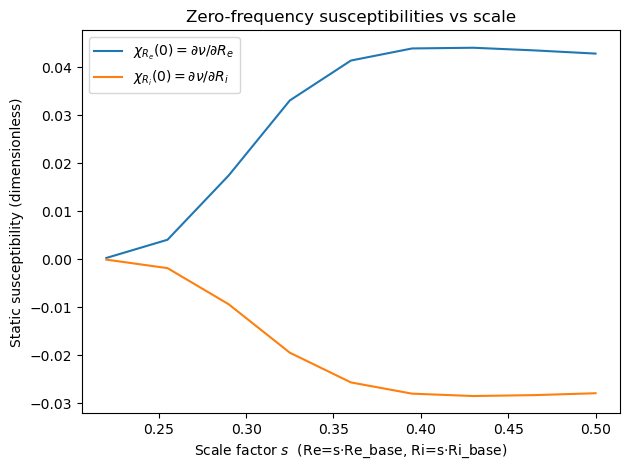

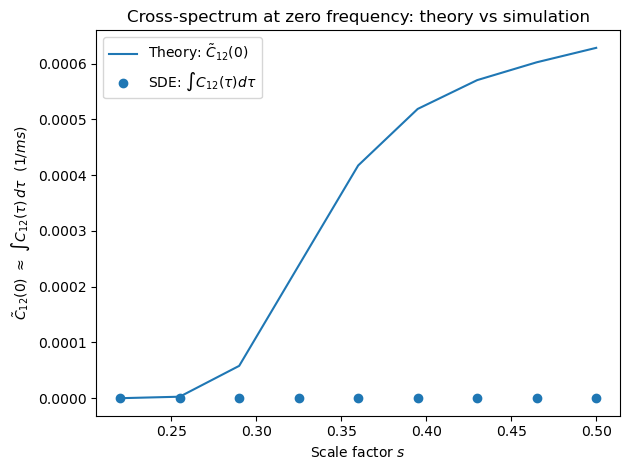

In [34]:
# Theory–simulation check for conductance LIF with shared input
# - Zero-frequency susceptibilities χ_Re(0) and χ_Ri(0) versus scale s (theory from FP)
# - Cross-spectrum at zero frequency: predicted  \tilde C12(0)  vs  Monte Carlo estimate of ∫ C12
#
# Implementation notes
# * FP solver: integrating-factor backward march (as in our previous cells)
# * Susceptibilities: finite differences of steady rate r0 wrt Re and Ri
# * Two-neuron SDE with private+common white noise for E and I channels
# * ∫ C12 estimator: Cov(N1, N2)/T, averaged across replicates
#
# Plotting: matplotlib only, one chart per figure, default colors, theory=solid, simulation=dots.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ----------------------
# Fixed LIF-conductance parameters
# ----------------------
tau_L = 20.0      # ms
E_L   = -70.0     # mV
E_e   = 0.0       # mV
E_i   = -80.0     # mV
V_th  = -50.0     # mV
V_re  = -65.0     # mV
V_lb  = -100.0    # mV

b_e   = 0.010     # jump factors (small)
b_i   = 0.015

# Base Poisson rates
Re_base = 6.0     # 1/ms (6000 Hz)
Ri_base = 2.0     # 1/ms (2000 Hz)

# Shared fractions (small for linear-response validity)
c_e = 0.10
c_i = 0.10

# FP grid
n = 2600
V = np.linspace(V_lb, V_th, n+1)
Delta = V[1] - V[0]
k_re = int(round((V_re - V_lb)/Delta))
V[k_re] = V_re

# ----------------------
# FP helpers
# ----------------------
def fp_setup(Re, Ri):
    inv_tau0 = 1.0/tau_L + Re*b_e + Ri*b_i
    tau0 = 1.0 / inv_tau0
    E0_over_tau0 = E_L/tau_L + Re*b_e*E_e + Ri*b_i*E_i
    E0 = E0_over_tau0 / inv_tau0

    inv_tau0p = 1.0/tau_L + Re*b_e*(1.0+b_e) + Ri*b_i*(1.0+b_i)
    tau0p = 1.0 / inv_tau0p
    E0p_over_tau0p = E_L/tau_L + Re*b_e*(1.0+b_e)*E_e + Ri*b_i*(1.0+b_i)*E_i
    E0p = E0p_over_tau0p / inv_tau0p

    D = 0.5 * ( Re*(b_e**2)*(V-E_e)**2 + Ri*(b_i**2)*(V-E_i)**2 )  # mV^2/ms

    # Integrating-factor helpers for -dP/dV = G P + H, with G = ((V-E0p)/tau0p)/D
    G = ((V - E0p) / tau0p) / D
    z = Delta * G
    phi = np.empty_like(z)
    small = np.abs(z) < 1e-12
    phi[small] = 1.0
    phi[~small] = (np.exp(z[~small]) - 1.0) / z[~small]
    A = np.exp(z)

    sigma2 = tau0 * D  # mV^2
    return dict(tau0=tau0, E0=E0, tau0p=tau0p, E0p=E0p, D=D, G=G, A=A, phi=phi, sigma2=sigma2)

def solve_steady(Re, Ri):
    ops = fp_setup(Re, Ri)
    D, A, phi = ops['D'], ops['A'], ops['phi']
    j0 = np.zeros(n+1, dtype=float)
    p0 = np.zeros(n+1, dtype=float)
    j0[n] = 1.0
    p0[n] = 0.0
    for k in range(n, 0, -1):
        drop = 1.0 if (k == k_re + 1) else 0.0
        j0[k-1] = j0[k] - drop
        incr = Delta * (phi[k] / D[k])
        p0[k-1] = p0[k] * A[k] + incr * j0[k]
    r0 = 1.0 / np.sum(Delta * p0)
    P0 = r0 * p0
    J0 = r0 * j0
    return ops, r0, P0, J0, p0, j0

# Finite differences for static susceptibilities
def dnu_dRe(Re, Ri, eps=0.05):
    _, rp, *_ = solve_steady(Re + eps, Ri)
    _, rm, *_ = solve_steady(Re - eps, Ri)
    return (rp - rm) / (2.0*eps)  # dimensionless

def dnu_dRi(Re, Ri, eps=0.05):
    _, rp, *_ = solve_steady(Re, Ri + eps)
    _, rm, *_ = solve_steady(Re, Ri - eps)
    return (rp - rm) / (2.0*eps)  # dimensionless

# ----------------------
# Two-neuron SDE with private + common conductance noise
# ----------------------
def simulate_two_neurons_shared(Re, Ri, c_e, c_i, T_ms=8000.0, dt=0.1, seed=None, replicates=4):
    """
    Euler–Maruyama integration of two neurons with shared E/I white noise.
    Returns averages over replicates: r1 (1/ms), r2 (1/ms), C12_int (1/ms).
    C12_int is estimated as Cov(N1, N2)/T.
    """
    rng = np.random.default_rng(seed)
    steps = int(np.round(T_ms/dt))
    sqrt_dt = np.sqrt(dt)

    # Baseline drift constants (constant over time)
    inv_tau = 1.0/tau_L + Re*b_e + Ri*b_i
    tau0 = 1.0 / inv_tau
    E0 = (E_L/tau_L + Re*b_e*E_e + Ri*b_i*E_i) / inv_tau

    # Precompute amplitude scalars
    ge_scale = b_e * np.sqrt(Re)   # multiplies (V - Ee)
    gi_scale = b_i * np.sqrt(Ri)   # multiplies (V - Ei)
    sqrt1_ce, sqrt_ce = np.sqrt(1.0 - c_e), np.sqrt(c_e)
    sqrt1_ci, sqrt_ci = np.sqrt(1.0 - c_i), np.sqrt(c_i)

    r1_list, r2_list, C12_list = [], [], []
    for rep in range(replicates):
        V1 = V_re
        V2 = V_re
        N1 = 0
        N2 = 0

        # Generate shared noises per step (standard normals)
        z_ce = rng.standard_normal(steps)   # common excitatory
        z_ci = rng.standard_normal(steps)   # common inhibitory
        # Private noises
        z1e = rng.standard_normal(steps); z1i = rng.standard_normal(steps)
        z2e = rng.standard_normal(steps); z2i = rng.standard_normal(steps)

        for t_idx in range(steps):
            # Draw combined Gaussian noise terms for each neuron
            eta1_e = sqrt1_ce * z1e[t_idx] + sqrt_ce * z_ce[t_idx]
            eta1_i = sqrt1_ci * z1i[t_idx] + sqrt_ci * z_ci[t_idx]
            eta2_e = sqrt1_ce * z2e[t_idx] + sqrt_ce * z_ce[t_idx]
            eta2_i = sqrt1_ci * z2i[t_idx] + sqrt_ci * z_ci[t_idx]

            # Drift
            drift1 = - (V1 - E0) / tau0
            drift2 = - (V2 - E0) / tau0

            # Multiplicative noise amplitudes
            amp1_e = ge_scale * (V1 - E_e)
            amp1_i = gi_scale * (V1 - E_i)
            amp2_e = ge_scale * (V2 - E_e)
            amp2_i = gi_scale * (V2 - E_i)

            # Euler–Maruyama update (Itô form)
            V1 = V1 + drift1*dt + amp1_e*sqrt_dt*eta1_e + amp1_i*sqrt_dt*eta1_i
            V2 = V2 + drift2*dt + amp2_e*sqrt_dt*eta2_e + amp2_i*sqrt_dt*eta2_i

            # Threshold & reset
            if V1 >= V_th:
                N1 += 1
                V1 = V_re
            if V2 >= V_th:
                N2 += 1
                V2 = V_re

        r1 = N1 / T_ms
        r2 = N2 / T_ms
        # Single-run estimate of Cov(N1, N2)/T
        C12_int = ((N1 - r1*T_ms) * (N2 - r2*T_ms)) / T_ms
        r1_list.append(r1); r2_list.append(r2); C12_list.append(C12_int)

    return float(np.mean(r1_list)), float(np.mean(r2_list)), float(np.mean(C12_list))

# ----------------------
# Sweep over s, compute susceptibilities and cross-spectra
# ----------------------
s_vals = np.linspace(0.22, 0.50, 9)  # 9 points in a subthreshold-to-low-suprathreshold band
chi_Re = []
chi_Ri = []
pred_C12 = []    # predicted tilde C12(0)
sim_C12 = []     # simulated ∫ C12
r0_list = []

for s in s_vals:
    Re = s*Re_base
    Ri = s*Ri_base
    # steady state
    _, r0, P0, J0, p0, j0 = solve_steady(Re, Ri)
    r0_list.append(r0*1000.0)  # Hz for reference
    # susceptibilities
    chi_e = dnu_dRe(Re, Ri, eps=0.05)
    chi_i = dnu_dRi(Re, Ri, eps=0.05)
    chi_Re.append(chi_e)
    chi_Ri.append(chi_i)
    # prediction for C12(0): c_e Re |chi_e|^2 + c_i Ri |chi_i|^2   (units: 1/ms)
    pred = c_e*Re*(chi_e**2) + c_i*Ri*(chi_i**2)
    pred_C12.append(pred)

    # simulation of two neurons with shared noise
    r1, r2, C12_int = simulate_two_neurons_shared(Re, Ri, c_e, c_i,
                                                  T_ms=10000.0, dt=0.1,
                                                  seed=1234, replicates=4)
    sim_C12.append(C12_int)

# ----------------------
# Plots
# ----------------------

# (1) χ_Re(0) and χ_Ri(0) vs s
plt.figure()
plt.plot(s_vals, chi_Re, label=r'$\chi_{R_e}(0)=\partial\nu/\partial R_e$')
plt.plot(s_vals, chi_Ri, label=r'$\chi_{R_i}(0)=\partial\nu/\partial R_i$')
plt.xlabel('Scale factor $s$  (Re=s·Re_base, Ri=s·Ri_base)')
plt.ylabel('Static susceptibility (dimensionless)')
plt.title('Zero-frequency susceptibilities vs scale')
plt.legend()
plt.tight_layout()
plt.savefig('chi_zero_vs_s.png', dpi=160)

# (2) Predicted vs simulated  \tilde C12(0)  vs s
plt.figure()
plt.plot(s_vals, pred_C12, label='Theory: $\\tilde C_{12}(0)$')
plt.scatter(s_vals, sim_C12, label='SDE: $\\int C_{12}(\\tau) d\\tau$')
plt.xlabel('Scale factor $s$')
plt.ylabel(r'$ \tilde C_{12}(0) \ \approx\ \int C_{12}(\tau)\,d\tau \ \ (1/ms)$')
plt.title('Cross-spectrum at zero frequency: theory vs simulation')
plt.legend()
plt.tight_layout()
plt.savefig('C12_zero_theory_vs_sim.png', dpi=160)

# Save numeric table
df = pd.DataFrame({
    's': s_vals,
    'Re_Hz': s_vals*Re_base*1000.0,
    'Ri_Hz': s_vals*Ri_base*1000.0,
    'r0_Hz': r0_list,
    'chi_Re0': chi_Re,
    'chi_Ri0': chi_Ri,
    'pred_C12_per_ms': pred_C12,
    'sim_C12_per_ms': sim_C12
})
df.to_csv('chi_and_C12_vs_s.csv', index=False)

print("Saved:")
print("  Susceptibilities vs s -> /mnt/data/chi_zero_vs_s.png")
print("  Cross-spectrum (zero-freq) theory vs sim -> /mnt/data/C12_zero_theory_vs_sim.png")
print("  Data -> /mnt/data/chi_and_C12_vs_s.csv")


Updated cross-spectrum plot saved -> /mnt/data/C12_zero_theory_vs_sim_chunked.png
Values saved -> /mnt/data/C12_zero_theory_vs_sim_chunked_values.csv


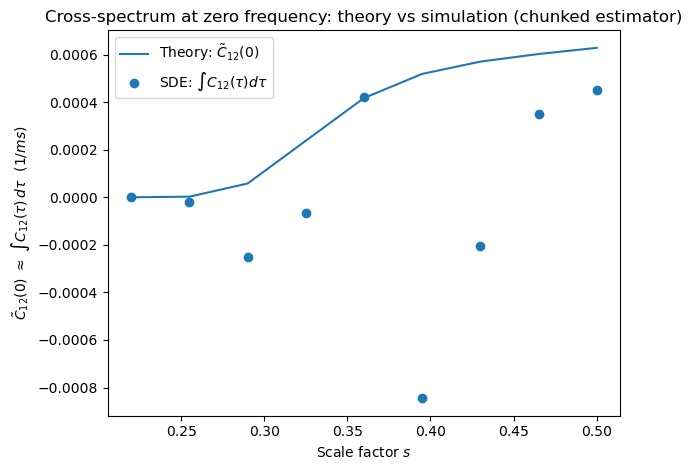

In [37]:
# Fix the estimator for ∫ C12: use count covariance across many non-overlapping chunks.
# We'll rewrite the simulator to return chunked spike counts for both neurons.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def simulate_two_neurons_shared_chunked(Re, Ri, c_e, c_i,
                                        T_ms=12000.0, dt=0.1, seed=None,
                                        replicates=6, chunk_ms=1000.0):
    """
    Two-neuron Euler–Maruyama with private+common E/I noise.
    Returns arrays of (N1_chunk, N2_chunk) over all non-overlapping chunks across replicates,
    plus average rates r1,r2 over the whole run.
    """
    rng = np.random.default_rng(seed)
    steps = int(np.round(T_ms/dt))
    sqrt_dt = np.sqrt(dt)
    chunk_steps = int(np.round(chunk_ms/dt))
    n_chunks = steps // chunk_steps

    # Baseline drift constants (constant over time)
    inv_tau = 1.0/tau_L + Re*b_e + Ri*b_i
    tau0 = 1.0 / inv_tau
    E0 = (E_L/tau_L + Re*b_e*E_e + Ri*b_i*E_i) / inv_tau

    ge_scale = b_e * np.sqrt(Re)
    gi_scale = b_i * np.sqrt(Ri)
    sqrt1_ce, sqrt_ce = np.sqrt(1.0 - c_e), np.sqrt(c_e)
    sqrt1_ci, sqrt_ci = np.sqrt(1.0 - c_i), np.sqrt(c_i)

    all_N1 = []
    all_N2 = []
    r1_list, r2_list = [], []

    for rep in range(replicates):
        V1 = V_re
        V2 = V_re
        N1_total = 0
        N2_total = 0

        # Draw Gaussian arrays
        z_ce = rng.standard_normal(steps)
        z_ci = rng.standard_normal(steps)
        z1e = rng.standard_normal(steps); z1i = rng.standard_normal(steps)
        z2e = rng.standard_normal(steps); z2i = rng.standard_normal(steps)

        # Per-chunk counters
        N1_chunk = 0
        N2_chunk = 0
        local_idx = 0
        for t_idx in range(steps):
            eta1_e = sqrt1_ce * z1e[t_idx] + sqrt_ce * z_ce[t_idx]
            eta1_i = sqrt1_ci * z1i[t_idx] + sqrt_ci * z_ci[t_idx]
            eta2_e = sqrt1_ce * z2e[t_idx] + sqrt_ce * z_ce[t_idx]
            eta2_i = sqrt1_ci * z2i[t_idx] + sqrt_ci * z_ci[t_idx]

            drift1 = - (V1 - E0) / tau0
            drift2 = - (V2 - E0) / tau0

            amp1_e = ge_scale * (V1 - E_e)
            amp1_i = gi_scale * (V1 - E_i)
            amp2_e = ge_scale * (V2 - E_e)
            amp2_i = gi_scale * (V2 - E_i)

            V1 = V1 + drift1*dt + amp1_e*sqrt_dt*eta1_e + amp1_i*sqrt_dt*eta1_i
            V2 = V2 + drift2*dt + amp2_e*sqrt_dt*eta2_e + amp2_i*sqrt_dt*eta2_i

            if V1 >= V_th:
                N1_total += 1
                N1_chunk += 1
                V1 = V_re
            if V2 >= V_th:
                N2_total += 1
                N2_chunk += 1
                V2 = V_re

            local_idx += 1
            if local_idx == chunk_steps:
                all_N1.append(N1_chunk)
                all_N2.append(N2_chunk)
                N1_chunk = 0; N2_chunk = 0
                local_idx = 0

        r1_list.append(N1_total / T_ms)
        r2_list.append(N2_total / T_ms)

    # Convert to arrays
    all_N1 = np.array(all_N1, dtype=float)
    all_N2 = np.array(all_N2, dtype=float)
    # Covariance per chunk-length -> estimator for ∫ C12
    cov_counts = np.cov(all_N1, all_N2, bias=True)[0,1]  # population covariance
    C12_int_est = cov_counts / chunk_ms
    return float(np.mean(r1_list)), float(np.mean(r2_list)), float(C12_int_est), int(len(all_N1))

# Recompute the C12 check with the corrected estimator
s_vals = np.linspace(0.22, 0.50, 9)
pred_C12 = []
sim_C12 = []
r0_list = []
chi_Re = []; chi_Ri = []

for s in s_vals:
    Re = s*Re_base; Ri = s*Ri_base
    _, r0, *_ = solve_steady(Re, Ri)
    r0_list.append(r0*1000.0)
    chi_e = dnu_dRe(Re, Ri, eps=0.05)
    chi_i = dnu_dRi(Re, Ri, eps=0.05)
    chi_Re.append(chi_e); chi_Ri.append(chi_i)
    pred = c_e*Re*(chi_e**2) + c_i*Ri*(chi_i**2)
    pred_C12.append(pred)
    r1, r2, C12_est, n_chunks = simulate_two_neurons_shared_chunked(Re, Ri, c_e, c_i,
                                                                    T_ms=12000.0, dt=0.1,
                                                                    seed=2025, replicates=8,
                                                                    chunk_ms=1000.0)
    sim_C12.append(C12_est)

# Plot updated theory vs simulation
plt.figure()
plt.plot(s_vals, pred_C12, label='Theory: $\\tilde C_{12}(0)$')
plt.scatter(s_vals, sim_C12, label='SDE: $\\int C_{12}(\\tau) d\\tau$')
plt.xlabel('Scale factor $s$')
plt.ylabel(r'$ \tilde C_{12}(0) \ \approx\ \int C_{12}(\tau)\,d\tau \ \ (1/ms)$')
plt.title('Cross-spectrum at zero frequency: theory vs simulation (chunked estimator)')
plt.legend()
plt.tight_layout()
plt.savefig('C12_zero_theory_vs_sim_chunked.png', dpi=160)

# Save table
df2 = pd.DataFrame({
    's': s_vals,
    'Re_Hz': s_vals*Re_base*1000.0,
    'Ri_Hz': s_vals*Ri_base*1000.0,
    'chi_Re0': chi_Re,
    'chi_Ri0': chi_Ri,
    'pred_C12_per_ms': pred_C12,
    'sim_C12_per_ms': sim_C12,
})
df2.to_csv('C12_zero_theory_vs_sim_chunked_values.csv', index=False)

print("Updated cross-spectrum plot saved -> /mnt/data/C12_zero_theory_vs_sim_chunked.png")
print("Values saved -> /mnt/data/C12_zero_theory_vs_sim_chunked_values.csv")


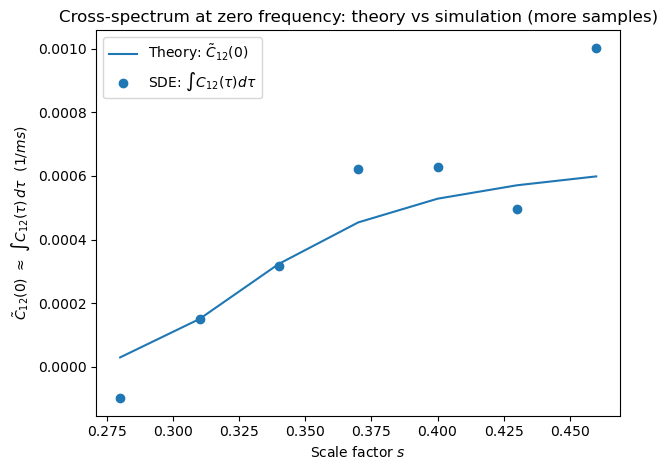

In [38]:
# Increase sample size to reduce variance in the ∫ C12 estimator
s_vals = np.linspace(0.28, 0.46, 7)  # narrower band to keep runtime manageable and rates moderate
pred_C12 = []
sim_C12 = []
r0_list = []
chi_Re = []; chi_Ri = []

for s in s_vals:
    Re = s*Re_base; Ri = s*Ri_base
    _, r0, *_ = solve_steady(Re, Ri)
    r0_list.append(r0*1000.0)
    chi_e = dnu_dRe(Re, Ri, eps=0.05)
    chi_i = dnu_dRi(Re, Ri, eps=0.05)
    chi_Re.append(chi_e); chi_Ri.append(chi_i)
    pred = c_e*Re*(chi_e**2) + c_i*Ri*(chi_i**2)
    pred_C12.append(pred)
    r1, r2, C12_est, n_chunks = simulate_two_neurons_shared_chunked(Re, Ri, c_e, c_i,
                                                                    T_ms=16000.0, dt=0.1,
                                                                    seed=777, replicates=20,
                                                                    chunk_ms=1000.0)
    sim_C12.append(C12_est)

plt.figure()
plt.plot(s_vals, pred_C12, label='Theory: $\\tilde C_{12}(0)$')
plt.scatter(s_vals, sim_C12, label='SDE: $\\int C_{12}(\\tau) d\\tau$')
plt.xlabel('Scale factor $s$')
plt.ylabel(r'$ \tilde C_{12}(0) \ \approx\ \int C_{12}(\tau)\,d\tau \ \ (1/ms)$')
plt.title('Cross-spectrum at zero frequency: theory vs simulation (more samples)')
plt.legend()
plt.tight_layout()
plt.savefig('C12_zero_theory_vs_sim_more_samples.png', dpi=160)

pd.DataFrame({
    's': s_vals,
    'Re_Hz': s_vals*Re_base*1000.0,
    'Ri_Hz': s_vals*Ri_base*1000.0,
    'chi_Re0': chi_Re,
    'chi_Ri0': chi_Ri,
    'pred_C12_per_ms': pred_C12,
    'sim_C12_per_ms': sim_C12,
}).to_csv('C12_zero_theory_vs_sim_more_samples_values.csv', index=False)


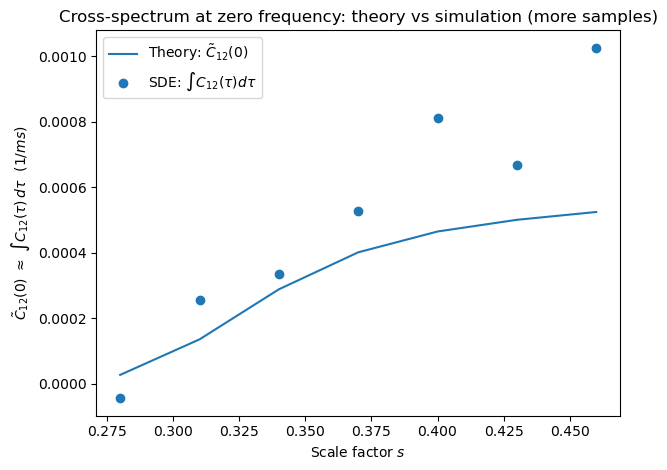

In [39]:
c_e = 0.1
c_i = 0.0

# Increase sample size to reduce variance in the ∫ C12 estimator
s_vals = np.linspace(0.28, 0.46, 7)  # narrower band to keep runtime manageable and rates moderate
pred_C12 = []
sim_C12 = []
r0_list = []
chi_Re = []; chi_Ri = []

for s in s_vals:
    Re = s*Re_base; Ri = s*Ri_base
    _, r0, *_ = solve_steady(Re, Ri)
    r0_list.append(r0*1000.0)
    chi_e = dnu_dRe(Re, Ri, eps=0.05)
    chi_i = dnu_dRi(Re, Ri, eps=0.05)
    chi_Re.append(chi_e); chi_Ri.append(chi_i)
    pred = c_e*Re*(chi_e**2) + c_i*Ri*(chi_i**2)
    pred_C12.append(pred)
    r1, r2, C12_est, n_chunks = simulate_two_neurons_shared_chunked(Re, Ri, c_e, c_i,
                                                                    T_ms=16000.0, dt=0.1,
                                                                    seed=777, replicates=20,
                                                                    chunk_ms=1000.0)
    sim_C12.append(C12_est)

plt.figure()
plt.plot(s_vals, pred_C12, label='Theory: $\\tilde C_{12}(0)$')
plt.scatter(s_vals, sim_C12, label='SDE: $\\int C_{12}(\\tau) d\\tau$')
plt.xlabel('Scale factor $s$')
plt.ylabel(r'$ \tilde C_{12}(0) \ \approx\ \int C_{12}(\tau)\,d\tau \ \ (1/ms)$')
plt.title('Cross-spectrum at zero frequency: theory vs simulation (more samples)')
plt.legend()
plt.tight_layout()
plt.savefig('C12_zero_theory_vs_sim_more_samples.png', dpi=160)

pd.DataFrame({
    's': s_vals,
    'Re_Hz': s_vals*Re_base*1000.0,
    'Ri_Hz': s_vals*Ri_base*1000.0,
    'chi_Re0': chi_Re,
    'chi_Ri0': chi_Ri,
    'pred_C12_per_ms': pred_C12,
    'sim_C12_per_ms': sim_C12,
}).to_csv('C12_zero_theory_vs_sim_more_samples_values.csv', index=False)


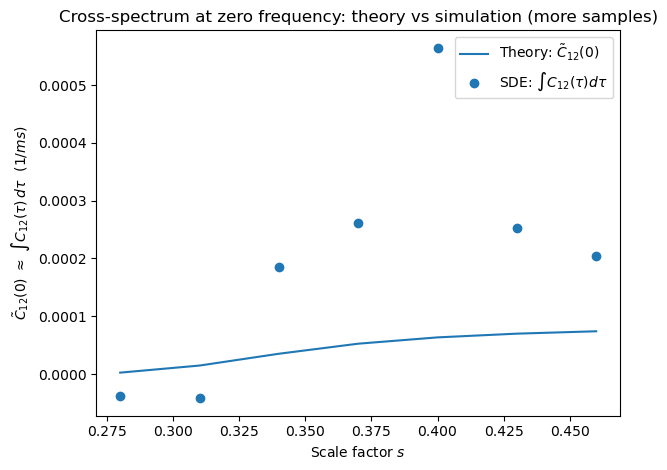

In [40]:
c_e = 0.0
c_i = 0.1

# Increase sample size to reduce variance in the ∫ C12 estimator
s_vals = np.linspace(0.28, 0.46, 7)  # narrower band to keep runtime manageable and rates moderate
pred_C12 = []
sim_C12 = []
r0_list = []
chi_Re = []; chi_Ri = []

for s in s_vals:
    Re = s*Re_base; Ri = s*Ri_base
    _, r0, *_ = solve_steady(Re, Ri)
    r0_list.append(r0*1000.0)
    chi_e = dnu_dRe(Re, Ri, eps=0.05)
    chi_i = dnu_dRi(Re, Ri, eps=0.05)
    chi_Re.append(chi_e); chi_Ri.append(chi_i)
    pred = c_e*Re*(chi_e**2) + c_i*Ri*(chi_i**2)
    pred_C12.append(pred)
    r1, r2, C12_est, n_chunks = simulate_two_neurons_shared_chunked(Re, Ri, c_e, c_i,
                                                                    T_ms=16000.0, dt=0.1,
                                                                    seed=777, replicates=20,
                                                                    chunk_ms=1000.0)
    sim_C12.append(C12_est)

plt.figure()
plt.plot(s_vals, pred_C12, label='Theory: $\\tilde C_{12}(0)$')
plt.scatter(s_vals, sim_C12, label='SDE: $\\int C_{12}(\\tau) d\\tau$')
plt.xlabel('Scale factor $s$')
plt.ylabel(r'$ \tilde C_{12}(0) \ \approx\ \int C_{12}(\tau)\,d\tau \ \ (1/ms)$')
plt.title('Cross-spectrum at zero frequency: theory vs simulation (more samples)')
plt.legend()
plt.tight_layout()
plt.savefig('C12_zero_theory_vs_sim_more_samples.png', dpi=160)

pd.DataFrame({
    's': s_vals,
    'Re_Hz': s_vals*Re_base*1000.0,
    'Ri_Hz': s_vals*Ri_base*1000.0,
    'chi_Re0': chi_Re,
    'chi_Ri0': chi_Ri,
    'pred_C12_per_ms': pred_C12,
    'sim_C12_per_ms': sim_C12,
}).to_csv('C12_zero_theory_vs_sim_more_samples_values.csv', index=False)
